In [1]:
## Load packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import cmocean
import sys
import pyfesom2 as pf
import numpy as np
from scipy.interpolate import griddata
from tqdm import tqdm

from pathlib import Path
#example_data_path = Path("../parcels_example_data/")
import parcels
from matplotlib import pyplot as plt
import cartopy
import datetime

/gxfs_home/geomar/smomw662/.local/lib/python3.11/site-packages/pyfesom2/climatology.py:14: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [3]:
def interpolate_at_level_zero(meshpath: str='../data/channel', str_id: str=None, year: int=None, method: str=None):
    """
    Interpolates data at level 0 for a given variable over time.

    Parameters:
    - meshpath (str): Path to the directory containing the data files.
    - str_id (str): Variable name to interpolate (e.g., 'v').
    - year (int): Year of the data file to use.
    - method (str): Interpolation method ('linear', 'cubic', or 'nearest').

    Returns:
    - v_grid (np.array): Interpolated data at level 0 over the specified time range.
    """
    alpha, beta, gamma=[0, 0, 0]
    print("mesh will be loaded")
    # Insert your custom path
    #meshpath = '../data/channel'
    #meshpath = '/gxfs_work/geomar/smomw662/fesom_parcels_001/data/channel'
    mesh = pf.load_mesh(meshpath, abg=[alpha, beta, gamma], usepickle = False)
    #resultpath = f'{meshpath}results/'
    
    print(meshpath)
    
    meshdiag = xr.open_mfdataset(f'{meshpath}/fesom.mesh.diag.nc')
    #print(meshdiag)
    
    # Use the 'elem' dimension size directly
    elem_n = meshdiag.dims["elem"]
    
    # Initialize arrays based on the number of elements #array full of zeros
    xx2 = np.zeros(shape=(elem_n)) 
    yy2 = np.zeros(shape=(elem_n))
    
    #mesh.x2 is the longitude in vector
    #mesh.y2 is the latitude in vector
    
    mesh.x2[mesh.elem[1,:]].mean(axis=0)
    
    #lon=mesh.x2; lat=mesh.y2;
    
    #aa = mesh.elem ---> these are the indices of the elements in the triangle
    ## the loops find the mean of triangle elements or the centroid
    for i in np.arange(0,elem_n):
        xx2[i]=mesh.x2[mesh.elem[i,:]].mean(axis=0)
        yy2[i]=mesh.y2[mesh.elem[i,:]].mean(axis=0)
    
    
    cyclic_length=4.5
    unglue = True
    if unglue:
        try:
            tri = np.loadtxt(f'{meshpath}/elem2d.out', skiprows=1, dtype=int)
            nodes = np.loadtxt(f'{meshpath}/nod2d.out', skiprows=1)
            xcoord, ycoord = nodes[:, 1], nodes[:, 2]
            xc, yc = xcoord[tri - 1], ycoord[tri - 1]
            xmin = xc.min(axis=1)
            for i in range(3):
                ai = np.where(xc[:, i] - xmin > cyclic_length / 2)
                xc[ai, i] -= cyclic_length
            X = xc.mean(axis=1)
            Y = yc.mean(axis=1)
        except FileNotFoundError:
            print("Required files for ungluing not found; skipping unglue step.")
    
    ## the grid
    #Sampling theorem
    #Define the target grid with shape (72, 292)
    lon_grid, lat_grid = np.meshgrid(
        np.linspace(X.min(), X.max(), 72*2),
        np.linspace(Y.min(), Y.max(), 292*2)
    )
    
    # Flattened original data arrays (21120,)
    X = X.flatten()
    Y = Y.flatten()
    
    # Combine X and Y into a single array of shape (21120, 2) for original coordinates
    coords = np.column_stack((X, Y))
    
    # Flatten the target grid for griddata
    target_coords = np.column_stack((lon_grid.flatten(), lat_grid.flatten()))
    # Load the dataset and select level 0
    dat1 = xr.open_dataset(f'{meshpath}/{str_id}.fesom.{year}.nc')[str_id]
    
    # Initialize output grid
    int_grid = np.zeros((292, 72, dat1.shape[0]))
    #time = np.zeros((dat1.shape[0],))
    # Flattened original data arrays (21120,)
    X = X.flatten()
    Y = Y.flatten()
    coords = np.column_stack((X, Y))  # Combine X and Y for original coordinates

    # Define the target grid
    lon_grid, lat_grid = np.meshgrid(
        np.linspace(X.min(), X.max(), 72),
        np.linspace(Y.min(), Y.max(), 292)
    )
    target_coords = np.column_stack((lon_grid.flatten(), lat_grid.flatten()))

    # Interpolate for each time step at level 0
    #for itime in tqdm(range(dat1.shape[0])):
    for itime in tqdm(range(100)): #try with 100 days

        dat2 = dat1.isel(time=itime, nz1=0).squeeze()  # Select level 0
        data_flat = dat2.values.flatten()

        # Interpolate the data to the target grid
        data_grid_flat = griddata(
            coords,          # Original element coordinates
            data_flat,       # Original data values
            target_coords,   # Target grid coordinates
            method=method    # Interpolation method
        )

        # Reshape interpolated data and assign to output array
        int_grid[:, :, itime] = data_grid_flat.reshape((292, 72))

        # Print date for each time step
        #print(dat1.time.values[itime].astype('datetime64[D]'))
        time = dat1.time.values
        #len(itime.keys())
    return int_grid, lon_grid,lat_grid, time

# Example usage
# meshpath = '/Users/dlizarbe/Documents/PhD/FESOM'
# v_grid_result = interpolate_at_level_zero(meshpath, str_id='v', year=1958, method='linear')


### Linear Interpolation

In [3]:
#meshpath = '/gxfs_work/geomar/smomw662/fesom_parcels_001/data/channel'
[u_grid_result,lonip,latip,time] = interpolate_at_level_zero(meshpath, str_id='u', year=1960, method='linear')

#w_grid_result = interpolate_at_level_zero(meshpath, str_id='w', year=1958, method='linear')

mesh will be loaded


/gxfs_home/geomar/smomw662/.local/lib/python3.11/site-packages/pyfesom2/load_mesh_data.py:189: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  file_content = pd.read_csv(
/gxfs_home/geomar/smomw662/.local/lib/python3.11/site-packages/pyfesom2/load_mesh_data.py:200: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  file_content = pd.read_csv(


Load 2d part of the mesh in 0 second(s)
/gxfs_work/geomar/smomw662/fesom_parcels_001/data/channel


/tmp/ipykernel_1338368/2423330111.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  elem_n = meshdiag.dims["elem"]
100%|█████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


In [4]:
v_grid_result = interpolate_at_level_zero(meshpath, str_id='v', year=1960, method='linear')[0]

mesh will be loaded


/gxfs_home/geomar/smomw662/.local/lib/python3.11/site-packages/pyfesom2/load_mesh_data.py:189: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  file_content = pd.read_csv(
/gxfs_home/geomar/smomw662/.local/lib/python3.11/site-packages/pyfesom2/load_mesh_data.py:200: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  file_content = pd.read_csv(


Load 2d part of the mesh in 0 second(s)
/gxfs_work/geomar/smomw662/fesom_parcels_001/data/channel


/tmp/ipykernel_1338368/2423330111.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  elem_n = meshdiag.dims["elem"]
100%|█████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]


In [5]:
v_grid_result.shape

(292, 72, 365)

In [116]:
# cmap = cmocean.cm.balance

# #bounds=np.linspace(vmin,vmax,100)
# fig, ax = plt.subplots(figsize=(5,20))
# #plt.gca().set_aspect('equal')

# im = ax.pcolormesh(lon, lat, v_grid_result[:,:,100], shading='auto', cmap=cmap) 


#### Now Parcels

In [6]:
print(type(v_grid_result))
print(type(u_grid_result))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
# Transpose the arrays to [time, lat, lon] if necessary
u = np.transpose(u_grid_result, (2, 0, 1))  # Transpose to [time, lat, lon]
v = np.transpose(v_grid_result, (2, 0, 1))  # Transpose to [time, lat, lon]


In [15]:
# origin_time = np.datetime64('1960-01-01T00:00:00', 'ns')

# # Convert the datetime64 array to seconds since the origin
# time_in_seconds = (time_coord - origin_time) / np.timedelta64(1, 's')

# Display the result
#print(time_in_seconds)

# Calculate 365 days in seconds
seconds_in_a_day = 24 * 60 * 60
total_seconds_in_365_days = 365 * seconds_in_a_day

# Create time_coord array representing each day over 365 days in seconds
time_coord = np.arange(0, total_seconds_in_365_days, seconds_in_a_day)

type(time_coord)

numpy.ndarray

In [9]:
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4

# Assuming `lon_grid`, `lat_grid`, and `time_coord` represent the coordinates for your data
lon_grid = lonip  # Replace with actual longitudes
lat_grid = latip   # Replace with actual latitudes
#time_coord = time # Replace with actual time data if available

# Define the fields directly from the numpy arrays
data_fields = {
    'U': Field('U', data=u, lon=lon_grid, lat=lat_grid, time=time_coord),
    'V': Field('V', data=v, lon=lon_grid, lat=lat_grid, time=time_coord)
}
# data_fields = {  
#     'U': Field('U', data=u, lon=lon_grid, lat=lat_grid),
#     'V': Field('V', data=v, lon=lon_grid, lat=lat_grid)
# }
# Create the FieldSet directly from the data fields dictionary
fieldset = FieldSet(**data_fields)

#cyclic or periodic boundary condition


In [20]:
data_fields

{'U': <parcels.field.Field at 0x15434080ad90>,
 'V': <parcels.field.Field at 0x1543434c4e10>}

#### Plot the Channel U and V

In [122]:
# lon = fieldset.U.grid.lon
# lat = fieldset.U.grid.lat

# # U is the eastward current velocity; we get it for the first time step (index 0)
# u_data = u[0, :, :]
# u_data = np.where(u_data == 0, np.nan, u_data)
# # Create a meshgrid of lon/lat for plotting purposes
# loni, lati = np.meshgrid(lon, lat)

# fig, ax = plt.subplots(figsize=(5,20))
# #plt.gca().set_aspect('equal')

# im = ax.pcolormesh(lon, lat, v_grid_result[:,:,100], shading='auto', cmap=cmap) 
# # # Create the plot
# # plt.figure(figsize=(10, 6))

# # # Use a scatter plot to visualize U data on lon/lat
# # plt.pcolormesh(lon, lat, u_data, cmap='RdBu',shading='nearest',vmin=-1, vmax=1)
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Eastward Velocity (U) [m/s]')

# # Add labels and title
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_title('Eastward Current Velocity (U)')

# # Show the plot
# plt.show()



#### Release particles

In [11]:
number_particles = 1_000
## we define the region of release 
lon_bds = np.min(fieldset.U.grid.lon), np.max(fieldset.U.grid.lon)
lat_bds = np.min(fieldset.U.grid.lat), np.max(fieldset.U.grid.lat)
#time_0 = fieldset.U.grid.time[0]

In [16]:
# from datetime import timedelta
time_0 = fieldset.U.grid.time[0]
type(fieldset.U.grid.time)
# time_0=time_coord[0]
# time_0
# print(time_coord)
# print(time_0)

numpy.ndarray

In [125]:

# pset = parcels.ParticleSet.from_list(
#     fieldset=fieldset,
#     pclass=parcels.JITParticle,
#     lon=np.random.uniform(*lon_bds, size=(number_particles, )),
#     lat=np.random.uniform(*lat_bds, size=(number_particles, )),
#     time=np.full(number_particles, time_0)
# )

In [17]:
# Now you can use the FieldSet for particle advection or other operations in Parcels
# Define a ParticleSet with some initial particles
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    pclass=parcels.JITParticle,
    lon=np.random.uniform(*lon_bds, size=(number_particles, )),
    lat=np.random.uniform(*lat_bds, size=(number_particles, )),
    time=time_0 + np.zeros(shape=(number_particles, ))
)

#### Execute Particles

In [18]:
def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

In [19]:
#we define the particle output file name
output_file = pset.ParticleFile(
    name="Parcels_FESOM5.zarr", outputdt=datetime.timedelta(hours=1)
)

#we execute the particle file name
pset.execute(
    [parcels.AdvectionRK4, CheckError],
    runtime=datetime.timedelta(days=90),
    dt=datetime.timedelta(minutes=10),
    output_file=output_file,
)

INFO: Output files are stored in Parcels_FESOM5.zarr.


INFO:parcels.tools.loggers:Output files are stored in Parcels_FESOM5.zarr.


  0%|                         | 7800.0/7776000.0 [00:00<06:14, 20716.45it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 0
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 10800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 14400
  output_file.write(self, time_at_startofloop)


  0%|                        | 29400.0/7776000.0 [00:00<02:27, 52550.31it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 18000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 21600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 25200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 28800
  output_file.write(self, time_at_startofloop)


  1%|▏                       | 43800.0/7776000.0 [00:00<02:04, 61867.14it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 32400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 36000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 39600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 43200
  output_file.write(self, time_at_startofloop)


  1%|▏                       | 58200.0/7776000.0 [00:01<01:56, 66449.04it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 46800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 50400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 54000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 57600
  output_file.write(self, time_at_startofloop)


  1%|▏                       | 72600.0/7776000.0 [00:01<01:51, 68944.24it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 61200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 64800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 68400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 72000
  output_file.write(self, time_at_startofloop)


  1%|▎                       | 87000.0/7776000.0 [00:01<01:50, 69806.28it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 75600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 79200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 82800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 86400
  output_file.write(self, time_at_startofloop)


  1%|▎                      | 101400.0/7776000.0 [00:01<01:49, 70095.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 90000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 93600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 97200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 100800
  output_file.write(self, time_at_startofloop)


  1%|▎                      | 115800.0/7776000.0 [00:02<01:48, 70401.60it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 104400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 108000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 111600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 115200
  output_file.write(self, time_at_startofloop)


  2%|▍                      | 130200.0/7776000.0 [00:02<01:48, 70789.63it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 118800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 122400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 126000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 129600
  output_file.write(self, time_at_startofloop)


  2%|▍                      | 144600.0/7776000.0 [00:02<01:48, 70338.90it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 133200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 136800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 140400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 144000
  output_file.write(self, time_at_startofloop)


  2%|▍                      | 159000.0/7776000.0 [00:02<01:48, 70262.38it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 147600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 151200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 154800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 158400
  output_file.write(self, time_at_startofloop)


  2%|▌                      | 173400.0/7776000.0 [00:02<01:49, 69444.70it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 162000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 165600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 169200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 172800
  output_file.write(self, time_at_startofloop)


  2%|▌                      | 187800.0/7776000.0 [00:03<01:48, 70040.71it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 176400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 180000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 183600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 187200
  output_file.write(self, time_at_startofloop)


  3%|▌                      | 202200.0/7776000.0 [00:03<01:47, 70483.48it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 190800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 194400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 198000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 201600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 205200
  output_file.write(self, time_at_startofloop)


  3%|▋                      | 219600.0/7776000.0 [00:03<01:41, 74698.33it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 208800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 212400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 216000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 219600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 223200
  output_file.write(self, time_at_startofloop)


  3%|▋                      | 234600.0/7776000.0 [00:03<01:47, 70356.34it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 226800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 230400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 234000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 237600
  output_file.write(self, time_at_startofloop)


  3%|▋                      | 249000.0/7776000.0 [00:03<01:46, 70349.31it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 241200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 244800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 248400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 252000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 255600
  output_file.write(self, time_at_startofloop)


  3%|▊                      | 267000.0/7776000.0 [00:04<01:46, 70366.96it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 259200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 262800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 266400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 270000
  output_file.write(self, time_at_startofloop)


  4%|▊                      | 281400.0/7776000.0 [00:04<01:46, 70334.27it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 273600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 277200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 280800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 284400
  output_file.write(self, time_at_startofloop)


  4%|▊                      | 295800.0/7776000.0 [00:04<01:46, 70182.00it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 288000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 291600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 295200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 298800
  output_file.write(self, time_at_startofloop)


  4%|▉                      | 313200.0/7776000.0 [00:04<01:39, 74798.25it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 302400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 306000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 309600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 313200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 316800
  output_file.write(self, time_at_startofloop)


  4%|▉                      | 331200.0/7776000.0 [00:05<01:39, 74766.98it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 320400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 324000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 327600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 331200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 334800
  output_file.write(self, time_at_startofloop)


  4%|█                      | 346200.0/7776000.0 [00:05<01:44, 70825.92it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 338400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 342000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 345600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 349200
  output_file.write(self, time_at_startofloop)


  5%|█                      | 363600.0/7776000.0 [00:05<01:39, 74834.09it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 352800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 356400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 360000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 363600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 367200
  output_file.write(self, time_at_startofloop)


  5%|█                      | 378600.0/7776000.0 [00:05<01:44, 70795.63it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 370800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 374400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 378000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 381600
  output_file.write(self, time_at_startofloop)


  5%|█▏                     | 393000.0/7776000.0 [00:05<01:44, 70483.18it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 385200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 388800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 392400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 396000
  output_file.write(self, time_at_startofloop)


  5%|█▏                     | 407400.0/7776000.0 [00:06<01:43, 70954.77it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 399600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 403200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 406800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 410400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 414000
  output_file.write(self, time_at_startofloop)


  5%|█▎                     | 425400.0/7776000.0 [00:06<01:45, 69810.44it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 417600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 421200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 424800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 428400
  output_file.write(self, time_at_startofloop)


  6%|█▎                     | 439800.0/7776000.0 [00:06<01:44, 70486.07it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 432000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 435600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 439200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 442800
  output_file.write(self, time_at_startofloop)


  6%|█▎                     | 454200.0/7776000.0 [00:06<01:43, 70484.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 446400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 450000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 453600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 457200
  output_file.write(self, time_at_startofloop)


  6%|█▍                     | 468600.0/7776000.0 [00:06<01:43, 70567.39it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 460800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 464400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 468000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 471600
  output_file.write(self, time_at_startofloop)


  6%|█▍                     | 483000.0/7776000.0 [00:07<01:43, 70668.96it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 475200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 478800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 482400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 486000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 489600
  output_file.write(self, time_at_startofloop)


  6%|█▍                     | 501000.0/7776000.0 [00:07<01:43, 70448.56it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 493200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 496800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 500400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 504000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 507600
  output_file.write(self, time_at_startofloop)


  7%|█▌                     | 526200.0/7776000.0 [00:07<01:42, 70908.69it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 511200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 514800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 518400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 522000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 525600
  output_file.write(self, time_at_startofloop)


  7%|█▌                     | 543600.0/7776000.0 [00:08<01:36, 75146.74it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 529200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 532800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 536400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 540000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 543600
  output_file.write(self, time_at_startofloop)


  7%|█▋                     | 558600.0/7776000.0 [00:08<01:41, 70816.92it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 547200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 550800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 554400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 558000
  output_file.write(self, time_at_startofloop)


  7%|█▋                     | 576600.0/7776000.0 [00:08<01:41, 70985.10it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 561600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 565200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 568800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 572400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 576000
  output_file.write(self, time_at_startofloop)


  8%|█▋                     | 591000.0/7776000.0 [00:08<01:41, 70799.83it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 579600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 583200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 586800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 590400
  output_file.write(self, time_at_startofloop)


  8%|█▊                     | 605400.0/7776000.0 [00:08<01:41, 70646.55it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 594000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 597600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 601200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 604800
  output_file.write(self, time_at_startofloop)


  8%|█▊                     | 619800.0/7776000.0 [00:09<01:40, 70939.36it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 608400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 612000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 615600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 619200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 622800
  output_file.write(self, time_at_startofloop)


  8%|█▉                     | 637800.0/7776000.0 [00:09<01:41, 70402.51it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 626400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 630000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 633600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 637200
  output_file.write(self, time_at_startofloop)


  8%|█▉                     | 652200.0/7776000.0 [00:09<01:40, 71047.84it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 640800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 644400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 648000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 651600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 655200
  output_file.write(self, time_at_startofloop)


  9%|█▉                     | 669600.0/7776000.0 [00:09<01:35, 74579.66it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 658800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 662400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 666000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 669600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 673200
  output_file.write(self, time_at_startofloop)


  9%|██                     | 687600.0/7776000.0 [00:10<01:34, 74783.18it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 676800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 680400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 684000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 687600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 691200
  output_file.write(self, time_at_startofloop)


  9%|██                     | 702600.0/7776000.0 [00:10<01:40, 70132.07it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 694800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 698400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 702000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 705600
  output_file.write(self, time_at_startofloop)


  9%|██                     | 717000.0/7776000.0 [00:10<01:40, 70275.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 709200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 712800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 716400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 720000
  output_file.write(self, time_at_startofloop)


  9%|██▏                    | 731400.0/7776000.0 [00:10<01:39, 70849.69it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 723600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 727200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 730800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 734400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 738000
  output_file.write(self, time_at_startofloop)


 10%|██▏                    | 756000.0/7776000.0 [00:10<01:33, 74711.17it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 741600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 745200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 748800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 752400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 756000
  output_file.write(self, time_at_startofloop)


 10%|██▎                    | 771000.0/7776000.0 [00:11<01:39, 70140.53it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 759600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 763200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 766800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 770400
  output_file.write(self, time_at_startofloop)


 10%|██▎                    | 785400.0/7776000.0 [00:11<01:39, 70440.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 774000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 777600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 781200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 784800
  output_file.write(self, time_at_startofloop)


 10%|██▎                    | 799800.0/7776000.0 [00:11<01:38, 70618.37it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 788400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 792000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 795600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 799200
  output_file.write(self, time_at_startofloop)


 11%|██▍                    | 817800.0/7776000.0 [00:11<01:38, 70298.88it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 802800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 806400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 810000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 813600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 817200
  output_file.write(self, time_at_startofloop)


 11%|██▍                    | 832200.0/7776000.0 [00:12<01:38, 70531.95it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 820800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 824400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 828000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 831600
  output_file.write(self, time_at_startofloop)


 11%|██▌                    | 846600.0/7776000.0 [00:12<01:38, 70404.61it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 835200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 838800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 842400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 846000
  output_file.write(self, time_at_startofloop)


 11%|██▌                    | 861000.0/7776000.0 [00:12<01:38, 70057.44it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 849600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 853200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 856800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 860400
  output_file.write(self, time_at_startofloop)


 11%|██▌                    | 868200.0/7776000.0 [00:12<01:38, 69959.99it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 864000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 867600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 871200
  output_file.write(self, time_at_startofloop)


 11%|██▌                    | 882600.0/7776000.0 [00:12<02:02, 56066.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 874800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 878400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 882000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 885600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 889200
  output_file.write(self, time_at_startofloop)


 12%|██▋                    | 907200.0/7776000.0 [00:13<01:42, 66947.92it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 892800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 896400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 900000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 903600
  output_file.write(self, time_at_startofloop)


 12%|██▋                    | 921600.0/7776000.0 [00:13<01:40, 68508.08it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 907200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 910800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 914400
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 918000
  output_file.write(self, time_at_startofloop)


 12%|██▊                    | 936000.0/7776000.0 [00:13<01:38, 69587.59it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 921600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 925200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 928800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 932400
  output_file.write(self, time_at_startofloop)


 12%|██▊                    | 943800.0/7776000.0 [00:13<01:41, 67614.50it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 936000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 939600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 943200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 946800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 950400
  output_file.write(self, time_at_startofloop)


 12%|██▊                    | 961800.0/7776000.0 [00:14<01:38, 69274.88it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 954000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 957600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 961200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 964800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 968400
  output_file.write(self, time_at_startofloop)


 13%|██▉                    | 987000.0/7776000.0 [00:14<01:36, 70345.90it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 972000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 975600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 979200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 982800
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 986400
  output_file.write(self, time_at_startofloop)


 13%|██▊                   | 1004400.0/7776000.0 [00:14<01:30, 74440.76it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 990000
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 993600
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 997200
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0008e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0044e+06
  output_file.write(self, time_at_startofloop)


 13%|██▉                   | 1022400.0/7776000.0 [00:14<01:30, 74485.76it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.008e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0116e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0152e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0188e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0224e+06
  output_file.write(self, time_at_startofloop)


 13%|██▉                   | 1037400.0/7776000.0 [00:15<01:35, 70667.95it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.026e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0296e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0332e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0368e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0404e+06
  output_file.write(self, time_at_startofloop)


 14%|██▉                   | 1051800.0/7776000.0 [00:15<01:34, 70859.15it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.044e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0476e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0512e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0548e+06
  output_file.write(self, time_at_startofloop)


 14%|███                   | 1066200.0/7776000.0 [00:15<01:35, 70606.83it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0584e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.062e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0656e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0692e+06
  output_file.write(self, time_at_startofloop)


 14%|███                   | 1080600.0/7776000.0 [00:15<01:35, 70324.52it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0728e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0764e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.08e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0836e+06
  output_file.write(self, time_at_startofloop)


 14%|███                   | 1095000.0/7776000.0 [00:15<01:34, 70739.89it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0872e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0908e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.0944e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.098e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1016e+06
  output_file.write(self, time_at_startofloop)


 14%|███▏                  | 1113000.0/7776000.0 [00:16<01:34, 70172.75it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1052e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1088e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1124e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.116e+06
  output_file.write(self, time_at_startofloop)


 14%|███▏                  | 1127400.0/7776000.0 [00:16<01:34, 70350.24it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1196e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1232e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1268e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1304e+06
  output_file.write(self, time_at_startofloop)


 15%|███▏                  | 1141800.0/7776000.0 [00:16<01:33, 70832.70it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.134e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1376e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1412e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1448e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1484e+06
  output_file.write(self, time_at_startofloop)


 15%|███▎                  | 1159800.0/7776000.0 [00:16<01:33, 70742.64it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.152e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1556e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1592e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1628e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1664e+06
  output_file.write(self, time_at_startofloop)


 15%|███▎                  | 1177800.0/7776000.0 [00:17<01:34, 69769.90it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.17e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1736e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1772e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1808e+06
  output_file.write(self, time_at_startofloop)


 15%|███▎                  | 1192200.0/7776000.0 [00:17<01:33, 70224.49it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1844e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.188e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1916e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1952e+06
  output_file.write(self, time_at_startofloop)


 16%|███▍                  | 1206600.0/7776000.0 [00:17<01:33, 70348.48it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.1988e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2024e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.206e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2096e+06
  output_file.write(self, time_at_startofloop)


 16%|███▍                  | 1224000.0/7776000.0 [00:17<01:27, 74721.15it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2132e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2168e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2204e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.224e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2276e+06
  output_file.write(self, time_at_startofloop)


 16%|███▌                  | 1239000.0/7776000.0 [00:17<01:32, 70912.98it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2312e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2348e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2384e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.242e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2456e+06
  output_file.write(self, time_at_startofloop)


 16%|███▌                  | 1264200.0/7776000.0 [00:18<01:31, 71221.92it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2492e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2528e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2564e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.26e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2636e+06
  output_file.write(self, time_at_startofloop)


 16%|███▌                  | 1274400.0/7776000.0 [00:18<01:26, 74964.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2672e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2708e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2744e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.278e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2816e+06
  output_file.write(self, time_at_startofloop)


 17%|███▋                  | 1296600.0/7776000.0 [00:18<01:31, 70958.29it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2852e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2888e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2924e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.296e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.2996e+06
  output_file.write(self, time_at_startofloop)


 17%|███▋                  | 1311000.0/7776000.0 [00:18<01:30, 71127.39it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3032e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3068e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3104e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.314e+06
  output_file.write(self, time_at_startofloop)


 17%|███▋                  | 1325400.0/7776000.0 [00:19<01:30, 71267.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3176e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3212e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3248e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3284e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.332e+06
  output_file.write(self, time_at_startofloop)


 17%|███▊                  | 1343400.0/7776000.0 [00:19<01:30, 71223.43it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3356e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3392e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3428e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3464e+06
  output_file.write(self, time_at_startofloop)


 17%|███▊                  | 1357800.0/7776000.0 [00:19<01:31, 70147.04it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.35e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3536e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3572e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3608e+06
  output_file.write(self, time_at_startofloop)


 18%|███▉                  | 1375800.0/7776000.0 [00:19<01:30, 70801.82it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3644e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.368e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3716e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3752e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3788e+06
  output_file.write(self, time_at_startofloop)


 18%|███▉                  | 1393800.0/7776000.0 [00:20<01:30, 70875.84it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3824e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.386e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3896e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3932e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.3968e+06
  output_file.write(self, time_at_startofloop)


 18%|███▉                  | 1408200.0/7776000.0 [00:20<01:30, 70724.68it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4004e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.404e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4076e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4112e+06
  output_file.write(self, time_at_startofloop)


 18%|████                  | 1425600.0/7776000.0 [00:20<01:25, 74491.08it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4148e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4184e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.422e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4256e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4292e+06
  output_file.write(self, time_at_startofloop)


 19%|████                  | 1443600.0/7776000.0 [00:20<01:25, 74492.01it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4328e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4364e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.44e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4436e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4472e+06
  output_file.write(self, time_at_startofloop)


 19%|████▏                 | 1458600.0/7776000.0 [00:20<01:28, 71224.52it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4508e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4544e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.458e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4616e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4652e+06
  output_file.write(self, time_at_startofloop)


 19%|████▏                 | 1483800.0/7776000.0 [00:21<01:28, 71433.24it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4688e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4724e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.476e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4796e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4832e+06
  output_file.write(self, time_at_startofloop)


 19%|████▏                 | 1501200.0/7776000.0 [00:21<01:23, 74834.71it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4868e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4904e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.494e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.4976e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5012e+06
  output_file.write(self, time_at_startofloop)


 19%|████▎                 | 1516200.0/7776000.0 [00:21<01:28, 70347.58it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5048e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5084e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.512e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5156e+06
  output_file.write(self, time_at_startofloop)


 20%|████▎                 | 1530600.0/7776000.0 [00:21<01:28, 70646.87it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5192e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5228e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5264e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.53e+06
  output_file.write(self, time_at_startofloop)


 20%|████▎                 | 1545000.0/7776000.0 [00:22<01:28, 70800.80it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5336e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5372e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5408e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5444e+06
  output_file.write(self, time_at_startofloop)


 20%|████▍                 | 1559400.0/7776000.0 [00:22<01:27, 70649.25it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.548e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5516e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5552e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5588e+06
  output_file.write(self, time_at_startofloop)


 20%|████▍                 | 1573800.0/7776000.0 [00:22<01:27, 70667.45it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5624e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.566e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5696e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5732e+06
  output_file.write(self, time_at_startofloop)


 20%|████▍                 | 1588200.0/7776000.0 [00:22<01:27, 70712.61it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5768e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5804e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.584e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5876e+06
  output_file.write(self, time_at_startofloop)


 21%|████▌                 | 1602600.0/7776000.0 [00:22<01:26, 71020.74it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5912e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5948e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.5984e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.602e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6056e+06
  output_file.write(self, time_at_startofloop)


 21%|████▌                 | 1620600.0/7776000.0 [00:23<01:26, 71037.95it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6092e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6128e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6164e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.62e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6236e+06
  output_file.write(self, time_at_startofloop)


 21%|████▋                 | 1638600.0/7776000.0 [00:23<01:26, 70636.52it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6272e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6308e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6344e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.638e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6416e+06
  output_file.write(self, time_at_startofloop)


 21%|████▋                 | 1653000.0/7776000.0 [00:23<01:26, 71002.41it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6452e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6488e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6524e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.656e+06
  output_file.write(self, time_at_startofloop)


 21%|████▋                 | 1667400.0/7776000.0 [00:23<01:26, 70751.72it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6596e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6632e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6668e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6704e+06
  output_file.write(self, time_at_startofloop)


 22%|████▊                 | 1681800.0/7776000.0 [00:24<01:27, 69957.32it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.674e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6776e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6812e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6848e+06
  output_file.write(self, time_at_startofloop)


 22%|████▊                 | 1696200.0/7776000.0 [00:24<01:27, 69760.49it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6884e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.692e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6956e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.6992e+06
  output_file.write(self, time_at_startofloop)


 22%|████▊                 | 1710600.0/7776000.0 [00:24<01:26, 70377.12it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7028e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7064e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.71e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7136e+06
  output_file.write(self, time_at_startofloop)


 22%|████▉                 | 1725000.0/7776000.0 [00:24<01:25, 70542.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7172e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7208e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7244e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.728e+06
  output_file.write(self, time_at_startofloop)


 22%|████▉                 | 1739400.0/7776000.0 [00:24<01:25, 70999.25it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7316e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7352e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7388e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7424e+06
  output_file.write(self, time_at_startofloop)


 23%|████▉                 | 1753800.0/7776000.0 [00:25<01:25, 70327.37it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.746e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7496e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7532e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7568e+06
  output_file.write(self, time_at_startofloop)


 23%|█████                 | 1768200.0/7776000.0 [00:25<01:25, 70420.94it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7604e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.764e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7676e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7712e+06
  output_file.write(self, time_at_startofloop)


 23%|█████                 | 1782600.0/7776000.0 [00:25<01:25, 70488.38it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7748e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7784e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.782e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7856e+06
  output_file.write(self, time_at_startofloop)


 23%|█████                 | 1797000.0/7776000.0 [00:25<01:24, 70484.97it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7892e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7928e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.7964e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8e+06
  output_file.write(self, time_at_startofloop)


 23%|█████                 | 1811400.0/7776000.0 [00:25<01:24, 70788.64it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8036e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8072e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8108e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8144e+06
  output_file.write(self, time_at_startofloop)


 23%|█████▏                | 1825800.0/7776000.0 [00:26<01:24, 70372.71it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.818e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8216e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8252e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8288e+06
  output_file.write(self, time_at_startofloop)


 24%|█████▏                | 1840200.0/7776000.0 [00:26<01:25, 69528.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8324e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.836e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8396e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8432e+06
  output_file.write(self, time_at_startofloop)


 24%|█████▏                | 1854600.0/7776000.0 [00:26<01:25, 69640.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8468e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8504e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.854e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8576e+06
  output_file.write(self, time_at_startofloop)


 24%|█████▎                | 1869000.0/7776000.0 [00:26<01:24, 70110.86it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8612e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8648e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8684e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.872e+06
  output_file.write(self, time_at_startofloop)


 24%|█████▎                | 1883400.0/7776000.0 [00:26<01:23, 70163.41it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8756e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8792e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8828e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8864e+06
  output_file.write(self, time_at_startofloop)


 24%|█████▎                | 1897800.0/7776000.0 [00:27<01:24, 69778.25it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.89e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8936e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.8972e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9008e+06
  output_file.write(self, time_at_startofloop)


 25%|█████▍                | 1912200.0/7776000.0 [00:27<01:23, 70041.07it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9044e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.908e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9116e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9152e+06
  output_file.write(self, time_at_startofloop)


 25%|█████▍                | 1930200.0/7776000.0 [00:27<01:23, 69842.03it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9188e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9224e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.926e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9296e+06
  output_file.write(self, time_at_startofloop)


 25%|█████▌                | 1944600.0/7776000.0 [00:27<01:22, 70389.58it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9332e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9368e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9404e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.944e+06
  output_file.write(self, time_at_startofloop)


 25%|█████▌                | 1959000.0/7776000.0 [00:28<01:22, 70353.77it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9476e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9512e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9548e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9584e+06
  output_file.write(self, time_at_startofloop)


 25%|█████▌                | 1977000.0/7776000.0 [00:28<01:22, 70277.33it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.962e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9656e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9692e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9728e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9764e+06
  output_file.write(self, time_at_startofloop)


 26%|█████▋                | 1991400.0/7776000.0 [00:28<01:21, 70931.77it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.98e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9836e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9872e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9908e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.9944e+06
  output_file.write(self, time_at_startofloop)


 26%|█████▋                | 2009400.0/7776000.0 [00:28<01:22, 70165.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 1.998e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0016e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0052e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0088e+06
  output_file.write(self, time_at_startofloop)


 26%|█████▋                | 2023800.0/7776000.0 [00:28<01:22, 69401.17it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0124e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.016e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0196e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0232e+06
  output_file.write(self, time_at_startofloop)


 26%|█████▊                | 2038200.0/7776000.0 [00:29<01:22, 69679.55it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0268e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0304e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.034e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0376e+06
  output_file.write(self, time_at_startofloop)


 26%|█████▊                | 2052600.0/7776000.0 [00:29<01:21, 70026.60it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0412e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0448e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0484e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.052e+06
  output_file.write(self, time_at_startofloop)


 27%|█████▊                | 2067000.0/7776000.0 [00:29<01:21, 69928.13it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0556e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0592e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0628e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0664e+06
  output_file.write(self, time_at_startofloop)


 27%|█████▉                | 2081400.0/7776000.0 [00:29<01:21, 70232.16it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.07e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0736e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0772e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0808e+06
  output_file.write(self, time_at_startofloop)


 27%|█████▉                | 2095800.0/7776000.0 [00:29<01:20, 70744.16it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0844e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.088e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0916e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0952e+06
  output_file.write(self, time_at_startofloop)


 27%|█████▉                | 2110200.0/7776000.0 [00:30<01:20, 70510.17it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.0988e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1024e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.106e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1096e+06
  output_file.write(self, time_at_startofloop)


 27%|██████                | 2124600.0/7776000.0 [00:30<01:20, 70377.45it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1132e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1168e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1204e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.124e+06
  output_file.write(self, time_at_startofloop)


 28%|██████                | 2139000.0/7776000.0 [00:30<01:20, 70202.59it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1276e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1312e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1348e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1384e+06
  output_file.write(self, time_at_startofloop)


 28%|██████                | 2153400.0/7776000.0 [00:30<01:19, 70388.87it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.142e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1456e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1492e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1528e+06
  output_file.write(self, time_at_startofloop)


 28%|██████▏               | 2167800.0/7776000.0 [00:30<01:20, 70074.08it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1564e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.16e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1636e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1672e+06
  output_file.write(self, time_at_startofloop)


 28%|██████▏               | 2182200.0/7776000.0 [00:31<01:19, 70114.67it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1708e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1744e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.178e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1816e+06
  output_file.write(self, time_at_startofloop)


 28%|██████▏               | 2196600.0/7776000.0 [00:31<01:19, 70215.27it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1852e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1888e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1924e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.196e+06
  output_file.write(self, time_at_startofloop)


 28%|██████▎               | 2211000.0/7776000.0 [00:31<01:20, 69204.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.1996e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2032e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2068e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2104e+06
  output_file.write(self, time_at_startofloop)


 29%|██████▎               | 2225400.0/7776000.0 [00:31<01:24, 65561.79it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.214e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2176e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2212e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2248e+06
  output_file.write(self, time_at_startofloop)


 29%|██████▎               | 2239800.0/7776000.0 [00:32<01:29, 62079.34it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2284e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.232e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2356e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2392e+06
  output_file.write(self, time_at_startofloop)


 29%|██████▍               | 2254200.0/7776000.0 [00:32<01:24, 65676.08it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2428e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2464e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.25e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2536e+06
  output_file.write(self, time_at_startofloop)


 29%|██████▍               | 2268600.0/7776000.0 [00:32<01:20, 68383.43it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2572e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2608e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2644e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.268e+06
  output_file.write(self, time_at_startofloop)


 29%|██████▍               | 2283000.0/7776000.0 [00:32<01:19, 69458.13it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2716e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2752e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2788e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2824e+06
  output_file.write(self, time_at_startofloop)


 30%|██████▍               | 2297400.0/7776000.0 [00:32<01:17, 70263.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.286e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2896e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2932e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.2968e+06
  output_file.write(self, time_at_startofloop)


 30%|██████▌               | 2311800.0/7776000.0 [00:33<01:18, 69721.63it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3004e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.304e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3076e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3112e+06
  output_file.write(self, time_at_startofloop)


 30%|██████▌               | 2326200.0/7776000.0 [00:33<01:17, 70301.86it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3148e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3184e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.322e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3256e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3292e+06
  output_file.write(self, time_at_startofloop)


 30%|██████▋               | 2344200.0/7776000.0 [00:33<01:16, 70932.04it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3328e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3364e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.34e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3436e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3472e+06
  output_file.write(self, time_at_startofloop)


 30%|██████▋               | 2361600.0/7776000.0 [00:33<01:12, 74897.89it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3508e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3544e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.358e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3616e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3652e+06
  output_file.write(self, time_at_startofloop)


 31%|██████▋               | 2376600.0/7776000.0 [00:33<01:16, 70685.02it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3688e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3724e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.376e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3796e+06
  output_file.write(self, time_at_startofloop)


 31%|██████▊               | 2391000.0/7776000.0 [00:34<01:16, 70737.67it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3832e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3868e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3904e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.394e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.3976e+06
  output_file.write(self, time_at_startofloop)


 31%|██████▊               | 2409000.0/7776000.0 [00:34<01:16, 69976.47it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4012e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4048e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4084e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.412e+06
  output_file.write(self, time_at_startofloop)


 31%|██████▊               | 2427000.0/7776000.0 [00:34<01:20, 66802.74it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4156e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4192e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4228e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4264e+06
  output_file.write(self, time_at_startofloop)


 31%|██████▉               | 2441400.0/7776000.0 [00:34<01:17, 69050.66it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.43e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4336e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4372e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4408e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4444e+06
  output_file.write(self, time_at_startofloop)


 32%|██████▉               | 2455800.0/7776000.0 [00:35<01:16, 69661.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.448e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4516e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4552e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4588e+06
  output_file.write(self, time_at_startofloop)


 32%|██████▉               | 2473200.0/7776000.0 [00:35<01:11, 74047.70it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4624e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.466e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4696e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4732e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4768e+06
  output_file.write(self, time_at_startofloop)


 32%|███████               | 2491200.0/7776000.0 [00:35<01:12, 73212.40it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4804e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.484e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4876e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4912e+06
  output_file.write(self, time_at_startofloop)


 32%|███████               | 2506200.0/7776000.0 [00:35<01:14, 70268.44it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4948e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.4984e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.502e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5056e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5092e+06
  output_file.write(self, time_at_startofloop)


 32%|███████▏              | 2520600.0/7776000.0 [00:36<01:14, 70498.05it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5128e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5164e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.52e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5236e+06
  output_file.write(self, time_at_startofloop)


 33%|███████▏              | 2535000.0/7776000.0 [00:36<01:14, 69885.79it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5272e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5308e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5344e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.538e+06
  output_file.write(self, time_at_startofloop)


 33%|███████▏              | 2549400.0/7776000.0 [00:36<01:14, 69917.65it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5416e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5452e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5488e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5524e+06
  output_file.write(self, time_at_startofloop)


 33%|███████▎              | 2563800.0/7776000.0 [00:36<01:14, 69988.23it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.556e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5596e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5632e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5668e+06
  output_file.write(self, time_at_startofloop)


 33%|███████▎              | 2578200.0/7776000.0 [00:36<01:13, 70244.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5704e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.574e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5776e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5812e+06
  output_file.write(self, time_at_startofloop)


 33%|███████▎              | 2595600.0/7776000.0 [00:37<01:10, 73955.32it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5848e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5884e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.592e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5956e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.5992e+06
  output_file.write(self, time_at_startofloop)


 34%|███████▍              | 2610600.0/7776000.0 [00:37<01:13, 69914.52it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6028e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6064e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.61e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6136e+06
  output_file.write(self, time_at_startofloop)


 34%|███████▍              | 2625000.0/7776000.0 [00:37<01:13, 70219.13it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6172e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6208e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6244e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.628e+06
  output_file.write(self, time_at_startofloop)


 34%|███████▍              | 2639400.0/7776000.0 [00:37<01:13, 70107.56it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6316e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6352e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6388e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6424e+06
  output_file.write(self, time_at_startofloop)


 34%|███████▌              | 2653800.0/7776000.0 [00:37<01:13, 70158.68it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.646e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6496e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6532e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6568e+06
  output_file.write(self, time_at_startofloop)


 34%|███████▌              | 2671800.0/7776000.0 [00:38<01:12, 70104.98it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6604e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.664e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6676e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6712e+06
  output_file.write(self, time_at_startofloop)


 35%|███████▌              | 2686200.0/7776000.0 [00:38<01:13, 69538.00it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6748e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6784e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.682e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6856e+06
  output_file.write(self, time_at_startofloop)


 35%|███████▋              | 2700600.0/7776000.0 [00:38<01:12, 69693.12it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6892e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6928e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.6964e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7e+06
  output_file.write(self, time_at_startofloop)


 35%|███████▋              | 2715000.0/7776000.0 [00:38<01:11, 70469.93it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7036e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7072e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7108e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7144e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.718e+06
  output_file.write(self, time_at_startofloop)


 35%|███████▋              | 2733000.0/7776000.0 [00:39<01:12, 69458.30it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7216e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7252e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7288e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7324e+06
  output_file.write(self, time_at_startofloop)


 35%|███████▊              | 2747400.0/7776000.0 [00:39<01:11, 70011.56it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.736e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7396e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7432e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7468e+06
  output_file.write(self, time_at_startofloop)


 36%|███████▊              | 2761800.0/7776000.0 [00:39<01:11, 69853.88it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7504e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.754e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7576e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7612e+06
  output_file.write(self, time_at_startofloop)


 36%|███████▊              | 2776200.0/7776000.0 [00:39<01:12, 69387.10it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7648e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7684e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.772e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7756e+06
  output_file.write(self, time_at_startofloop)


 36%|███████▉              | 2790600.0/7776000.0 [00:39<01:11, 69374.07it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7792e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7828e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7864e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.79e+06
  output_file.write(self, time_at_startofloop)


 36%|███████▉              | 2805000.0/7776000.0 [00:40<01:11, 69814.70it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7936e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.7972e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8008e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8044e+06
  output_file.write(self, time_at_startofloop)


 36%|███████▉              | 2819400.0/7776000.0 [00:40<01:11, 68945.39it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.808e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8116e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8152e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8188e+06
  output_file.write(self, time_at_startofloop)


 36%|████████              | 2833800.0/7776000.0 [00:40<01:11, 69587.79it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8224e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.826e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8296e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8332e+06
  output_file.write(self, time_at_startofloop)


 37%|████████              | 2848200.0/7776000.0 [00:40<01:10, 70055.48it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8368e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8404e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.844e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8476e+06
  output_file.write(self, time_at_startofloop)


 37%|████████              | 2862600.0/7776000.0 [00:40<01:09, 70645.22it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8512e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8548e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8584e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.862e+06
  output_file.write(self, time_at_startofloop)


 37%|████████▏             | 2877000.0/7776000.0 [00:41<01:09, 70431.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8656e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8692e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8728e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8764e+06
  output_file.write(self, time_at_startofloop)


 37%|████████▏             | 2891400.0/7776000.0 [00:41<01:09, 70169.76it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.88e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8836e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8872e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8908e+06
  output_file.write(self, time_at_startofloop)


 37%|████████▏             | 2908800.0/7776000.0 [00:41<01:05, 74699.09it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.8944e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.898e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9016e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9052e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9088e+06
  output_file.write(self, time_at_startofloop)


 38%|████████▎             | 2923800.0/7776000.0 [00:41<01:09, 70053.43it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9124e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.916e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9196e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9232e+06
  output_file.write(self, time_at_startofloop)


 38%|████████▎             | 2941200.0/7776000.0 [00:42<01:05, 74026.59it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9268e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9304e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.934e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9376e+06
  output_file.write(self, time_at_startofloop)


 38%|████████▎             | 2949000.0/7776000.0 [00:42<01:09, 69796.84it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9412e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9448e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9484e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.952e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9556e+06
  output_file.write(self, time_at_startofloop)


 38%|████████▍             | 2970600.0/7776000.0 [00:42<01:08, 70262.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9592e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9628e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9664e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.97e+06
  output_file.write(self, time_at_startofloop)


 38%|████████▍             | 2988000.0/7776000.0 [00:42<01:03, 75371.90it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9736e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9772e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9808e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9844e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.988e+06
  output_file.write(self, time_at_startofloop)


 39%|████████▌             | 3006000.0/7776000.0 [00:42<01:03, 75218.84it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9916e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9952e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 2.9988e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0024e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.006e+06
  output_file.write(self, time_at_startofloop)


 39%|████████▌             | 3021000.0/7776000.0 [00:43<01:06, 71293.30it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0096e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0132e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0168e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0204e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.024e+06
  output_file.write(self, time_at_startofloop)


 39%|████████▌             | 3038400.0/7776000.0 [00:43<01:03, 74774.71it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0276e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0312e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0348e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0384e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.042e+06
  output_file.write(self, time_at_startofloop)


 39%|████████▋             | 3056400.0/7776000.0 [00:43<01:03, 74459.61it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0456e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0492e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0528e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0564e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.06e+06
  output_file.write(self, time_at_startofloop)


 40%|████████▋             | 3074400.0/7776000.0 [00:43<01:03, 74482.88it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0636e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0672e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0708e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0744e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.078e+06
  output_file.write(self, time_at_startofloop)


 40%|████████▋             | 3092400.0/7776000.0 [00:44<01:03, 74252.82it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0816e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0852e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0888e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0924e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.096e+06
  output_file.write(self, time_at_startofloop)


 40%|████████▊             | 3110400.0/7776000.0 [00:44<01:02, 74099.96it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.0996e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1032e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1068e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1104e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.114e+06
  output_file.write(self, time_at_startofloop)


 40%|████████▊             | 3125400.0/7776000.0 [00:44<01:05, 70917.80it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1176e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1212e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1248e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1284e+06
  output_file.write(self, time_at_startofloop)


 40%|████████▉             | 3139800.0/7776000.0 [00:44<01:05, 70723.58it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.132e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1356e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1392e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1428e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1464e+06
  output_file.write(self, time_at_startofloop)


 41%|████████▉             | 3157800.0/7776000.0 [00:45<01:06, 69545.92it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.15e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1536e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1572e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1608e+06
  output_file.write(self, time_at_startofloop)


 41%|████████▉             | 3175800.0/7776000.0 [00:45<01:05, 70372.45it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1644e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.168e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1716e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1752e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1788e+06
  output_file.write(self, time_at_startofloop)


 41%|█████████             | 3193800.0/7776000.0 [00:45<01:05, 69799.77it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1824e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.186e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1896e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1932e+06
  output_file.write(self, time_at_startofloop)


 41%|█████████             | 3208200.0/7776000.0 [00:45<01:05, 70130.78it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.1968e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2004e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.204e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2076e+06
  output_file.write(self, time_at_startofloop)


 41%|█████████             | 3222600.0/7776000.0 [00:45<01:04, 70534.71it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2112e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2148e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2184e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.222e+06
  output_file.write(self, time_at_startofloop)


 42%|█████████▏            | 3237000.0/7776000.0 [00:46<01:04, 70349.27it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2256e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2292e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2328e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2364e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.24e+06
  output_file.write(self, time_at_startofloop)


 42%|█████████▏            | 3255000.0/7776000.0 [00:46<01:03, 71436.38it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2436e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2472e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2508e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2544e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.258e+06
  output_file.write(self, time_at_startofloop)


 42%|█████████▎            | 3273000.0/7776000.0 [00:46<01:03, 70809.60it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2616e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2652e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2688e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2724e+06
  output_file.write(self, time_at_startofloop)


 42%|█████████▎            | 3287400.0/7776000.0 [00:46<01:03, 70349.74it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.276e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2796e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2832e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2868e+06
  output_file.write(self, time_at_startofloop)


 42%|█████████▎            | 3304800.0/7776000.0 [00:47<01:00, 73747.46it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2904e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.294e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.2976e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3012e+06
  output_file.write(self, time_at_startofloop)


 43%|█████████▎            | 3312600.0/7776000.0 [00:47<01:03, 69942.12it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3048e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3084e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.312e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3156e+06
  output_file.write(self, time_at_startofloop)


 43%|█████████▍            | 3327000.0/7776000.0 [00:47<01:03, 70144.30it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3192e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3228e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3264e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.33e+06
  output_file.write(self, time_at_startofloop)


 43%|█████████▍            | 3341400.0/7776000.0 [00:47<01:03, 69958.75it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3336e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3372e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3408e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3444e+06
  output_file.write(self, time_at_startofloop)


 43%|█████████▌            | 3359400.0/7776000.0 [00:47<01:03, 69805.05it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.348e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3516e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3552e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3588e+06
  output_file.write(self, time_at_startofloop)


 43%|█████████▌            | 3373800.0/7776000.0 [00:48<01:02, 70407.79it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3624e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.366e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3696e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3732e+06
  output_file.write(self, time_at_startofloop)


 44%|█████████▌            | 3388200.0/7776000.0 [00:48<01:01, 71097.76it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3768e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3804e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.384e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3876e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3912e+06
  output_file.write(self, time_at_startofloop)


 44%|█████████▋            | 3402600.0/7776000.0 [00:48<01:01, 70694.61it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3948e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.3984e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.402e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4056e+06
  output_file.write(self, time_at_startofloop)


 44%|█████████▋            | 3417000.0/7776000.0 [00:48<01:02, 70073.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4092e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4128e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4164e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.42e+06
  output_file.write(self, time_at_startofloop)


 44%|█████████▋            | 3431400.0/7776000.0 [00:48<01:02, 69656.06it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4236e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4272e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4308e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4344e+06
  output_file.write(self, time_at_startofloop)


 44%|█████████▋            | 3445800.0/7776000.0 [00:49<01:01, 70189.15it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.438e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4416e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4452e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4488e+06
  output_file.write(self, time_at_startofloop)


 44%|█████████▊            | 3460200.0/7776000.0 [00:49<01:00, 70805.51it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4524e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.456e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4596e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4632e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4668e+06
  output_file.write(self, time_at_startofloop)


 45%|█████████▊            | 3478200.0/7776000.0 [00:49<01:01, 70032.80it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4704e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.474e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4776e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4812e+06
  output_file.write(self, time_at_startofloop)


 45%|█████████▉            | 3492600.0/7776000.0 [00:49<01:00, 70339.51it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4848e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4884e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.492e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4956e+06
  output_file.write(self, time_at_startofloop)


 45%|█████████▉            | 3507000.0/7776000.0 [00:49<01:00, 70580.37it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.4992e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5028e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5064e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.51e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5136e+06
  output_file.write(self, time_at_startofloop)


 45%|█████████▉            | 3525000.0/7776000.0 [00:50<01:00, 70542.96it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5172e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5208e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5244e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.528e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5316e+06
  output_file.write(self, time_at_startofloop)


 46%|██████████            | 3543000.0/7776000.0 [00:50<01:00, 70010.24it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5352e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5388e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5424e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.546e+06
  output_file.write(self, time_at_startofloop)


 46%|██████████            | 3557400.0/7776000.0 [00:50<00:59, 70486.80it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5496e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5532e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5568e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5604e+06
  output_file.write(self, time_at_startofloop)


 46%|██████████            | 3571800.0/7776000.0 [00:50<00:59, 70211.30it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.564e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5676e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5712e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5748e+06
  output_file.write(self, time_at_startofloop)


 46%|██████████▏           | 3586200.0/7776000.0 [00:51<00:59, 69891.43it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5784e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.582e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5856e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5892e+06
  output_file.write(self, time_at_startofloop)


 46%|██████████▏           | 3603600.0/7776000.0 [00:51<00:56, 74261.95it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5928e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.5964e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6036e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6072e+06
  output_file.write(self, time_at_startofloop)


 47%|██████████▏           | 3618600.0/7776000.0 [00:51<00:59, 69915.10it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6108e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6144e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.618e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6216e+06
  output_file.write(self, time_at_startofloop)


 47%|██████████▎           | 3636000.0/7776000.0 [00:51<00:55, 74379.88it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6252e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6288e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6324e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.636e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6396e+06
  output_file.write(self, time_at_startofloop)


 47%|██████████▎           | 3651000.0/7776000.0 [00:51<00:58, 70117.99it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6432e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6468e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6504e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.654e+06
  output_file.write(self, time_at_startofloop)


 47%|██████████▎           | 3665400.0/7776000.0 [00:52<00:58, 70064.11it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6576e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6612e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6648e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6684e+06
  output_file.write(self, time_at_startofloop)


 47%|██████████▍           | 3682800.0/7776000.0 [00:52<00:55, 74092.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.672e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6756e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6792e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6828e+06
  output_file.write(self, time_at_startofloop)


 48%|██████████▍           | 3697800.0/7776000.0 [00:52<00:58, 69563.31it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6864e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.69e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6936e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.6972e+06
  output_file.write(self, time_at_startofloop)


 48%|██████████▌           | 3712200.0/7776000.0 [00:52<00:58, 69557.36it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7008e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7044e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.708e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7116e+06
  output_file.write(self, time_at_startofloop)


 48%|██████████▌           | 3726600.0/7776000.0 [00:53<00:57, 69931.12it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7152e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7188e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7224e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.726e+06
  output_file.write(self, time_at_startofloop)


 48%|██████████▌           | 3741000.0/7776000.0 [00:53<00:57, 69992.12it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7296e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7332e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7368e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7404e+06
  output_file.write(self, time_at_startofloop)


 48%|██████████▋           | 3758400.0/7776000.0 [00:53<00:53, 74516.05it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.744e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7476e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7512e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7548e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7584e+06
  output_file.write(self, time_at_startofloop)


 49%|██████████▋           | 3773400.0/7776000.0 [00:53<00:57, 70158.00it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.762e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7656e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7692e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7728e+06
  output_file.write(self, time_at_startofloop)


 49%|██████████▋           | 3787800.0/7776000.0 [00:53<00:57, 69947.48it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7764e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.78e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7836e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7872e+06
  output_file.write(self, time_at_startofloop)


 49%|██████████▊           | 3802200.0/7776000.0 [00:54<00:56, 70523.04it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7908e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.7944e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.798e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8016e+06
  output_file.write(self, time_at_startofloop)


 49%|██████████▊           | 3819600.0/7776000.0 [00:54<00:52, 74757.06it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8052e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8088e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8124e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.816e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8196e+06
  output_file.write(self, time_at_startofloop)


 49%|██████████▊           | 3834600.0/7776000.0 [00:54<00:55, 70807.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8232e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8268e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8304e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.834e+06
  output_file.write(self, time_at_startofloop)


 49%|██████████▉           | 3849000.0/7776000.0 [00:54<00:55, 71344.72it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8376e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8412e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8448e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8484e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.852e+06
  output_file.write(self, time_at_startofloop)


 50%|██████████▉           | 3867000.0/7776000.0 [00:55<00:54, 71510.31it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8556e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8592e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8628e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8664e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.87e+06
  output_file.write(self, time_at_startofloop)


 50%|██████████▉           | 3885000.0/7776000.0 [00:55<00:55, 70614.52it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8736e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8772e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8808e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8844e+06
  output_file.write(self, time_at_startofloop)


 50%|███████████           | 3899400.0/7776000.0 [00:55<00:55, 70204.12it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.888e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8916e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8952e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.8988e+06
  output_file.write(self, time_at_startofloop)


 50%|███████████           | 3913800.0/7776000.0 [00:55<00:55, 70024.65it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9024e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.906e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9096e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9132e+06
  output_file.write(self, time_at_startofloop)


 51%|███████████           | 3928200.0/7776000.0 [00:55<00:54, 70537.56it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9168e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9204e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.924e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9276e+06
  output_file.write(self, time_at_startofloop)


 51%|███████████▏          | 3945600.0/7776000.0 [00:56<00:51, 74822.61it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9312e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9348e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9384e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.942e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9456e+06
  output_file.write(self, time_at_startofloop)


 51%|███████████▏          | 3960600.0/7776000.0 [00:56<00:54, 69491.32it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9492e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9528e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9564e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.96e+06
  output_file.write(self, time_at_startofloop)


 51%|███████████▏          | 3975000.0/7776000.0 [00:56<00:54, 69775.65it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9636e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9672e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9708e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9744e+06
  output_file.write(self, time_at_startofloop)


 51%|███████████▎          | 3985200.0/7776000.0 [00:56<00:51, 74290.09it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.978e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9816e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9852e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9888e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9924e+06
  output_file.write(self, time_at_startofloop)


 52%|███████████▎          | 4007400.0/7776000.0 [00:57<00:53, 70602.00it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.996e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 3.9996e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0032e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0068e+06
  output_file.write(self, time_at_startofloop)


 52%|███████████▍          | 4021800.0/7776000.0 [00:57<00:53, 70413.39it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0104e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.014e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0176e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0212e+06
  output_file.write(self, time_at_startofloop)


 52%|███████████▍          | 4036200.0/7776000.0 [00:57<00:52, 70648.48it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0248e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0284e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.032e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0356e+06
  output_file.write(self, time_at_startofloop)


 52%|███████████▍          | 4046400.0/7776000.0 [00:57<00:50, 74326.57it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0392e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0428e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0464e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.05e+06
  output_file.write(self, time_at_startofloop)


 52%|███████████▍          | 4061400.0/7776000.0 [00:57<00:53, 69884.32it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0536e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0572e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0608e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0644e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.068e+06
  output_file.write(self, time_at_startofloop)


 52%|███████████▌          | 4079400.0/7776000.0 [00:58<00:52, 69763.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0716e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0752e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0788e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0824e+06
  output_file.write(self, time_at_startofloop)


 53%|███████████▌          | 4096800.0/7776000.0 [00:58<00:49, 73908.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.086e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0896e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0932e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.0968e+06
  output_file.write(self, time_at_startofloop)


 53%|███████████▌          | 4104600.0/7776000.0 [00:58<00:52, 69419.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1004e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.104e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1076e+06
  output_file.write(self, time_at_startofloop)


 53%|███████████▋          | 4119000.0/7776000.0 [00:58<01:08, 53424.18it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1112e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1148e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1184e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.122e+06
  output_file.write(self, time_at_startofloop)


 53%|███████████▋          | 4136400.0/7776000.0 [00:58<00:56, 64978.70it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1256e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1292e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1328e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1364e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.14e+06
  output_file.write(self, time_at_startofloop)


 53%|███████████▊          | 4154400.0/7776000.0 [00:59<00:52, 69445.56it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1436e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1472e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1508e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1544e+06
  output_file.write(self, time_at_startofloop)


 54%|███████████▊          | 4168800.0/7776000.0 [00:59<00:52, 69023.27it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.158e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1616e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1652e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1688e+06
  output_file.write(self, time_at_startofloop)


 54%|███████████▊          | 4183200.0/7776000.0 [00:59<00:51, 69457.08it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1724e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.176e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1796e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1832e+06
  output_file.write(self, time_at_startofloop)


 54%|███████████▉          | 4197600.0/7776000.0 [00:59<00:50, 70246.43it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1868e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1904e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.194e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.1976e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2012e+06
  output_file.write(self, time_at_startofloop)


 54%|███████████▉          | 4212600.0/7776000.0 [01:00<00:51, 68557.01it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2048e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2084e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.212e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2156e+06
  output_file.write(self, time_at_startofloop)


 54%|███████████▉          | 4227000.0/7776000.0 [01:00<00:50, 69818.50it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2192e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2228e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2264e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.23e+06
  output_file.write(self, time_at_startofloop)


 55%|███████████▉          | 4241400.0/7776000.0 [01:00<00:50, 69922.10it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2336e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2372e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2408e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2444e+06
  output_file.write(self, time_at_startofloop)


 55%|████████████          | 4255800.0/7776000.0 [01:00<00:50, 69588.96it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.248e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2516e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2552e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2588e+06
  output_file.write(self, time_at_startofloop)


 55%|████████████          | 4270200.0/7776000.0 [01:00<00:51, 68543.00it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2624e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.266e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2696e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2732e+06
  output_file.write(self, time_at_startofloop)


 55%|████████████          | 4284600.0/7776000.0 [01:01<00:52, 66719.05it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2768e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2804e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.284e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2876e+06
  output_file.write(self, time_at_startofloop)


 55%|████████████▏         | 4299000.0/7776000.0 [01:01<00:51, 67543.79it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2912e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2948e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.2984e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.302e+06
  output_file.write(self, time_at_startofloop)


 56%|████████████▏         | 4317000.0/7776000.0 [01:01<00:50, 68708.45it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3056e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3092e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3128e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3164e+06
  output_file.write(self, time_at_startofloop)


 56%|████████████▎         | 4331400.0/7776000.0 [01:01<00:49, 69089.83it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.32e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3236e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3272e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3308e+06
  output_file.write(self, time_at_startofloop)


 56%|████████████▎         | 4349400.0/7776000.0 [01:02<00:49, 69813.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3344e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.338e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3416e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3452e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3488e+06
  output_file.write(self, time_at_startofloop)


 56%|████████████▎         | 4363800.0/7776000.0 [01:02<00:48, 70502.53it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3524e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.356e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3596e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3632e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3668e+06
  output_file.write(self, time_at_startofloop)


 56%|████████████▍         | 4378200.0/7776000.0 [01:02<00:47, 70903.40it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3704e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.374e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3776e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3812e+06
  output_file.write(self, time_at_startofloop)


 56%|████████████▍         | 4392600.0/7776000.0 [01:02<00:47, 70551.15it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3848e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3884e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.392e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3956e+06
  output_file.write(self, time_at_startofloop)


 57%|████████████▍         | 4410600.0/7776000.0 [01:02<00:47, 70219.31it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.3992e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4028e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4064e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.41e+06
  output_file.write(self, time_at_startofloop)


 57%|████████████▌         | 4425000.0/7776000.0 [01:03<00:47, 70260.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4136e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4172e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4208e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4244e+06
  output_file.write(self, time_at_startofloop)


 57%|████████████▌         | 4442400.0/7776000.0 [01:03<00:44, 74168.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.428e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4316e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4352e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4388e+06
  output_file.write(self, time_at_startofloop)


 57%|████████████▌         | 4450200.0/7776000.0 [01:03<00:47, 69702.93it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4424e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.446e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4496e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4532e+06
  output_file.write(self, time_at_startofloop)


 57%|████████████▋         | 4464600.0/7776000.0 [01:03<00:47, 69625.17it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4568e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4604e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.464e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4676e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4712e+06
  output_file.write(self, time_at_startofloop)


 58%|████████████▋         | 4482600.0/7776000.0 [01:03<00:46, 70848.52it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4748e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4784e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.482e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4856e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4892e+06
  output_file.write(self, time_at_startofloop)


 58%|████████████▋         | 4500600.0/7776000.0 [01:04<00:46, 70779.41it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4928e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.4964e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5036e+06
  output_file.write(self, time_at_startofloop)


 58%|████████████▊         | 4515000.0/7776000.0 [01:04<00:46, 70312.21it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5072e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5108e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5144e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.518e+06
  output_file.write(self, time_at_startofloop)


 58%|████████████▊         | 4529400.0/7776000.0 [01:04<00:45, 70825.09it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5216e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5252e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5288e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5324e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.536e+06
  output_file.write(self, time_at_startofloop)


 59%|████████████▉         | 4554600.0/7776000.0 [01:04<00:45, 71200.24it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5396e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5432e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5468e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5504e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.554e+06
  output_file.write(self, time_at_startofloop)


 59%|████████████▉         | 4569000.0/7776000.0 [01:05<00:45, 71085.94it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5576e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5612e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5648e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5684e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.572e+06
  output_file.write(self, time_at_startofloop)


 59%|████████████▉         | 4587000.0/7776000.0 [01:05<00:44, 71456.22it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5756e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5792e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5828e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5864e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.59e+06
  output_file.write(self, time_at_startofloop)


 59%|█████████████         | 4605000.0/7776000.0 [01:05<00:45, 69805.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5936e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.5972e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6008e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6044e+06
  output_file.write(self, time_at_startofloop)


 59%|█████████████         | 4619400.0/7776000.0 [01:05<00:44, 70352.71it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.608e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6116e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6152e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6188e+06
  output_file.write(self, time_at_startofloop)


 60%|█████████████         | 4633800.0/7776000.0 [01:06<00:44, 70548.51it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6224e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.626e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6296e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6332e+06
  output_file.write(self, time_at_startofloop)


 60%|█████████████▏        | 4648200.0/7776000.0 [01:06<00:44, 70715.81it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6368e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6404e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.644e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6476e+06
  output_file.write(self, time_at_startofloop)


 60%|█████████████▏        | 4665600.0/7776000.0 [01:06<00:41, 74710.95it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6512e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6548e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6584e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.662e+06
  output_file.write(self, time_at_startofloop)


 60%|█████████████▏        | 4673400.0/7776000.0 [01:06<00:44, 70263.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6656e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6692e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6728e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6764e+06
  output_file.write(self, time_at_startofloop)


 60%|█████████████▎        | 4687800.0/7776000.0 [01:06<00:43, 70462.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.68e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6836e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6872e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6908e+06
  output_file.write(self, time_at_startofloop)


 60%|█████████████▎        | 4702200.0/7776000.0 [01:06<00:43, 70670.04it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.6944e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.698e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7016e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7052e+06
  output_file.write(self, time_at_startofloop)


 61%|█████████████▎        | 4719600.0/7776000.0 [01:07<00:41, 74441.61it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7088e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7124e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.716e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7196e+06
  output_file.write(self, time_at_startofloop)


 61%|█████████████▍        | 4734600.0/7776000.0 [01:07<00:43, 70371.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7232e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7268e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7304e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.734e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7376e+06
  output_file.write(self, time_at_startofloop)


 61%|█████████████▍        | 4752600.0/7776000.0 [01:07<00:42, 71237.22it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7412e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7448e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7484e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.752e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7556e+06
  output_file.write(self, time_at_startofloop)


 61%|█████████████▍        | 4770000.0/7776000.0 [01:07<00:40, 74943.22it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7592e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7628e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7664e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.77e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7736e+06
  output_file.write(self, time_at_startofloop)


 62%|█████████████▌        | 4785000.0/7776000.0 [01:08<00:41, 71281.33it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7772e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7808e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7844e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.788e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7916e+06
  output_file.write(self, time_at_startofloop)


 62%|█████████████▌        | 4803000.0/7776000.0 [01:08<00:42, 70727.19it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7952e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.7988e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8024e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.806e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8096e+06
  output_file.write(self, time_at_startofloop)


 62%|█████████████▋        | 4828200.0/7776000.0 [01:08<00:41, 70659.60it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8132e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8168e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8204e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.824e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8276e+06
  output_file.write(self, time_at_startofloop)


 62%|█████████████▋        | 4842600.0/7776000.0 [01:08<00:41, 71118.27it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8312e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8348e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8384e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.842e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8456e+06
  output_file.write(self, time_at_startofloop)


 62%|█████████████▋        | 4857000.0/7776000.0 [01:09<00:40, 71214.07it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8492e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8528e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8564e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.86e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8636e+06
  output_file.write(self, time_at_startofloop)


 63%|█████████████▊        | 4875000.0/7776000.0 [01:09<00:40, 71129.07it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8672e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8708e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8744e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.878e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8816e+06
  output_file.write(self, time_at_startofloop)


 63%|█████████████▊        | 4893000.0/7776000.0 [01:09<00:40, 71049.06it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8852e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8888e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8924e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.896e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.8996e+06
  output_file.write(self, time_at_startofloop)


 63%|█████████████▉        | 4914600.0/7776000.0 [01:09<00:40, 70947.55it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9032e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9068e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9104e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.914e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9176e+06
  output_file.write(self, time_at_startofloop)


 63%|█████████████▉        | 4932600.0/7776000.0 [01:10<00:39, 71756.46it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9212e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9248e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9284e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.932e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9356e+06
  output_file.write(self, time_at_startofloop)


 64%|█████████████▉        | 4947000.0/7776000.0 [01:10<00:39, 71203.45it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9392e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9428e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9464e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.95e+06
  output_file.write(self, time_at_startofloop)


 64%|██████████████        | 4961400.0/7776000.0 [01:10<00:40, 70357.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9536e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9572e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9608e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9644e+06
  output_file.write(self, time_at_startofloop)


 64%|██████████████        | 4975800.0/7776000.0 [01:10<00:40, 69895.25it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.968e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9716e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9752e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9788e+06
  output_file.write(self, time_at_startofloop)


 64%|██████████████▏       | 4993800.0/7776000.0 [01:11<00:39, 70096.06it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9824e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.986e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9896e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9932e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 4.9968e+06
  output_file.write(self, time_at_startofloop)


 64%|██████████████▏       | 5011200.0/7776000.0 [01:11<00:37, 74301.66it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0004e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.004e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0076e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0112e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0148e+06
  output_file.write(self, time_at_startofloop)


 65%|██████████████▏       | 5026200.0/7776000.0 [01:11<00:38, 70511.38it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0184e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.022e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0256e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0292e+06
  output_file.write(self, time_at_startofloop)


 65%|██████████████▎       | 5040600.0/7776000.0 [01:11<00:38, 70437.18it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0328e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0364e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.04e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0436e+06
  output_file.write(self, time_at_startofloop)


 65%|██████████████▎       | 5058000.0/7776000.0 [01:11<00:36, 74301.26it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0472e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0508e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0544e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.058e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0616e+06
  output_file.write(self, time_at_startofloop)


 65%|██████████████▎       | 5076000.0/7776000.0 [01:12<00:36, 74115.24it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0652e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0688e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0724e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.076e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0796e+06
  output_file.write(self, time_at_startofloop)


 66%|██████████████▍       | 5094000.0/7776000.0 [01:12<00:35, 75266.87it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0832e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0868e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0904e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.094e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.0976e+06
  output_file.write(self, time_at_startofloop)


 66%|██████████████▍       | 5109000.0/7776000.0 [01:12<00:37, 71143.30it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1012e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1048e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1084e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.112e+06
  output_file.write(self, time_at_startofloop)


 66%|██████████████▌       | 5126400.0/7776000.0 [01:12<00:35, 74803.53it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1156e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1192e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1228e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1264e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.13e+06
  output_file.write(self, time_at_startofloop)


 66%|██████████████▌       | 5148600.0/7776000.0 [01:13<00:36, 71402.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1336e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1372e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1408e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1444e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.148e+06
  output_file.write(self, time_at_startofloop)


 66%|██████████████▌       | 5163000.0/7776000.0 [01:13<00:36, 71013.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1516e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1552e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1588e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1624e+06
  output_file.write(self, time_at_startofloop)


 67%|██████████████▋       | 5177400.0/7776000.0 [01:13<00:36, 71040.84it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.166e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1696e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1732e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1768e+06
  output_file.write(self, time_at_startofloop)


 67%|██████████████▋       | 5191800.0/7776000.0 [01:13<00:36, 70461.33it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1804e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.184e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1876e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1912e+06
  output_file.write(self, time_at_startofloop)


 67%|██████████████▋       | 5206200.0/7776000.0 [01:14<00:36, 70737.77it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1948e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.1984e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.202e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2056e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2092e+06
  output_file.write(self, time_at_startofloop)


 67%|██████████████▊       | 5224200.0/7776000.0 [01:14<00:36, 70489.29it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2128e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2164e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.22e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2236e+06
  output_file.write(self, time_at_startofloop)


 67%|██████████████▊       | 5242200.0/7776000.0 [01:14<00:35, 71292.48it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2272e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2308e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2344e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.238e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2416e+06
  output_file.write(self, time_at_startofloop)


 68%|██████████████▊       | 5256600.0/7776000.0 [01:14<00:35, 71064.34it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2452e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2488e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2524e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.256e+06
  output_file.write(self, time_at_startofloop)


 68%|██████████████▉       | 5271000.0/7776000.0 [01:14<00:35, 71046.10it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2596e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2632e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2668e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2704e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.274e+06
  output_file.write(self, time_at_startofloop)


 68%|██████████████▉       | 5289000.0/7776000.0 [01:15<00:35, 70864.31it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2776e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2812e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2848e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2884e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.292e+06
  output_file.write(self, time_at_startofloop)


 68%|███████████████       | 5307000.0/7776000.0 [01:15<00:34, 71151.83it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2956e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.2992e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3028e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3064e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.31e+06
  output_file.write(self, time_at_startofloop)


 68%|███████████████       | 5321400.0/7776000.0 [01:15<00:34, 71006.51it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3136e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3172e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3208e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3244e+06
  output_file.write(self, time_at_startofloop)


 69%|███████████████       | 5335800.0/7776000.0 [01:15<00:34, 71073.77it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.328e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3316e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3352e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3388e+06
  output_file.write(self, time_at_startofloop)


 69%|███████████████▏      | 5350200.0/7776000.0 [01:16<00:34, 71335.24it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3424e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.346e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3496e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3532e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3568e+06
  output_file.write(self, time_at_startofloop)


 69%|███████████████▏      | 5375400.0/7776000.0 [01:16<00:33, 70990.82it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3604e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.364e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3676e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3712e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3748e+06
  output_file.write(self, time_at_startofloop)


 69%|███████████████▏      | 5389800.0/7776000.0 [01:16<00:33, 70486.53it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3784e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.382e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3856e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3892e+06
  output_file.write(self, time_at_startofloop)


 69%|███████████████▎      | 5404200.0/7776000.0 [01:16<00:33, 69985.70it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3928e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.3964e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4036e+06
  output_file.write(self, time_at_startofloop)


 70%|███████████████▎      | 5418600.0/7776000.0 [01:16<00:33, 70001.17it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4072e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4108e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4144e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.418e+06
  output_file.write(self, time_at_startofloop)


 70%|███████████████▎      | 5433000.0/7776000.0 [01:17<00:33, 70574.32it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4216e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4252e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4288e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4324e+06
  output_file.write(self, time_at_startofloop)


 70%|███████████████▍      | 5450400.0/7776000.0 [01:17<00:31, 74777.57it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.436e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4396e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4432e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4468e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4504e+06
  output_file.write(self, time_at_startofloop)


 70%|███████████████▍      | 5465400.0/7776000.0 [01:17<00:33, 69892.16it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.454e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4576e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4612e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4648e+06
  output_file.write(self, time_at_startofloop)


 70%|███████████████▌      | 5479800.0/7776000.0 [01:17<00:32, 70190.71it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4684e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.472e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4756e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4792e+06
  output_file.write(self, time_at_startofloop)


 71%|███████████████▌      | 5497200.0/7776000.0 [01:18<00:30, 74611.75it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4828e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4864e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.49e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4936e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.4972e+06
  output_file.write(self, time_at_startofloop)


 71%|███████████████▌      | 5512200.0/7776000.0 [01:18<00:32, 70209.82it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5008e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5044e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.508e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5116e+06
  output_file.write(self, time_at_startofloop)


 71%|███████████████▋      | 5526600.0/7776000.0 [01:18<00:32, 70046.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5152e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5188e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5224e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.526e+06
  output_file.write(self, time_at_startofloop)


 71%|███████████████▋      | 5541000.0/7776000.0 [01:18<00:32, 69710.51it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5296e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5332e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5368e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5404e+06
  output_file.write(self, time_at_startofloop)


 71%|███████████████▋      | 5555400.0/7776000.0 [01:18<00:31, 69985.13it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.544e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5476e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5512e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5548e+06
  output_file.write(self, time_at_startofloop)


 72%|███████████████▊      | 5569800.0/7776000.0 [01:19<00:31, 69443.38it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5584e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.562e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5656e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5692e+06
  output_file.write(self, time_at_startofloop)


 72%|███████████████▊      | 5584200.0/7776000.0 [01:19<00:31, 69364.83it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5728e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5764e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.58e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5836e+06
  output_file.write(self, time_at_startofloop)


 72%|███████████████▊      | 5601600.0/7776000.0 [01:19<00:29, 74034.33it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5872e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5908e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.5944e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.598e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6016e+06
  output_file.write(self, time_at_startofloop)


 72%|███████████████▉      | 5616600.0/7776000.0 [01:19<00:30, 69746.83it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6052e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6088e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6124e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.616e+06
  output_file.write(self, time_at_startofloop)


 72%|███████████████▉      | 5631000.0/7776000.0 [01:19<00:30, 69988.64it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6196e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6232e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6268e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6304e+06
  output_file.write(self, time_at_startofloop)


 73%|███████████████▉      | 5645400.0/7776000.0 [01:20<00:30, 69579.99it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.634e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6376e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6412e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6448e+06
  output_file.write(self, time_at_startofloop)


 73%|████████████████      | 5659800.0/7776000.0 [01:20<00:30, 69891.25it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6484e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.652e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6556e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6592e+06
  output_file.write(self, time_at_startofloop)


 73%|████████████████      | 5674200.0/7776000.0 [01:20<00:29, 70340.27it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6628e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6664e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.67e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6736e+06
  output_file.write(self, time_at_startofloop)


 73%|████████████████      | 5688600.0/7776000.0 [01:20<00:29, 70242.34it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6772e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6808e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6844e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.688e+06
  output_file.write(self, time_at_startofloop)


 73%|████████████████▏     | 5703000.0/7776000.0 [01:21<00:29, 69989.39it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6916e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6952e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.6988e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7024e+06
  output_file.write(self, time_at_startofloop)


 74%|████████████████▏     | 5720400.0/7776000.0 [01:21<00:27, 73854.16it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.706e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7096e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7132e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7168e+06
  output_file.write(self, time_at_startofloop)


 74%|████████████████▏     | 5728200.0/7776000.0 [01:21<00:29, 69420.88it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7204e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.724e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7276e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7312e+06
  output_file.write(self, time_at_startofloop)


 74%|████████████████▏     | 5742600.0/7776000.0 [01:21<00:29, 69355.34it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7348e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7384e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.742e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7456e+06
  output_file.write(self, time_at_startofloop)


 74%|████████████████▎     | 5757000.0/7776000.0 [01:21<00:28, 69639.74it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7492e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7528e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7564e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.76e+06
  output_file.write(self, time_at_startofloop)


 74%|████████████████▎     | 5771400.0/7776000.0 [01:22<00:28, 69689.85it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7636e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7672e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7708e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7744e+06
  output_file.write(self, time_at_startofloop)


 74%|████████████████▎     | 5785800.0/7776000.0 [01:22<00:28, 70186.99it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.778e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7816e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7852e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7888e+06
  output_file.write(self, time_at_startofloop)


 75%|████████████████▍     | 5800200.0/7776000.0 [01:22<00:28, 70495.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7924e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.796e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.7996e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8032e+06
  output_file.write(self, time_at_startofloop)


 75%|████████████████▍     | 5821800.0/7776000.0 [01:22<00:27, 71294.00it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8068e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8104e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.814e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8176e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8212e+06
  output_file.write(self, time_at_startofloop)


 75%|████████████████▌     | 5836200.0/7776000.0 [01:22<00:27, 70985.24it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8248e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8284e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.832e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8356e+06
  output_file.write(self, time_at_startofloop)


 75%|████████████████▌     | 5850600.0/7776000.0 [01:23<00:27, 70483.17it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8392e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8428e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8464e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.85e+06
  output_file.write(self, time_at_startofloop)


 75%|████████████████▌     | 5865000.0/7776000.0 [01:23<00:27, 70223.18it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8536e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8572e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8608e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8644e+06
  output_file.write(self, time_at_startofloop)


 76%|████████████████▋     | 5879400.0/7776000.0 [01:23<00:26, 70482.47it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.868e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8716e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8752e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8788e+06
  output_file.write(self, time_at_startofloop)


 76%|████████████████▋     | 5893800.0/7776000.0 [01:23<00:26, 69894.15it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8824e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.886e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8896e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8932e+06
  output_file.write(self, time_at_startofloop)


 76%|████████████████▋     | 5908200.0/7776000.0 [01:23<00:27, 69173.31it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.8968e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9004e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.904e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9076e+06
  output_file.write(self, time_at_startofloop)


 76%|████████████████▊     | 5922600.0/7776000.0 [01:24<00:26, 69581.07it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9112e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9148e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9184e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.922e+06
  output_file.write(self, time_at_startofloop)


 76%|████████████████▊     | 5940000.0/7776000.0 [01:24<00:24, 73632.37it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9256e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9292e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9328e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9364e+06
  output_file.write(self, time_at_startofloop)


 76%|████████████████▊     | 5947800.0/7776000.0 [01:24<00:26, 69391.98it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.94e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9436e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9472e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9508e+06
  output_file.write(self, time_at_startofloop)


 77%|████████████████▊     | 5962200.0/7776000.0 [01:24<00:26, 69442.04it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9544e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.958e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9616e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9652e+06
  output_file.write(self, time_at_startofloop)


 77%|████████████████▉     | 5976600.0/7776000.0 [01:24<00:25, 69843.14it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9688e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9724e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.976e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9796e+06
  output_file.write(self, time_at_startofloop)


 77%|████████████████▉     | 5991000.0/7776000.0 [01:25<00:25, 69389.75it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9832e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9868e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9904e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.994e+06
  output_file.write(self, time_at_startofloop)


 77%|████████████████▉     | 6005400.0/7776000.0 [01:25<00:25, 69521.74it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 5.9976e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0012e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0048e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0084e+06
  output_file.write(self, time_at_startofloop)


 77%|█████████████████     | 6019800.0/7776000.0 [01:25<00:25, 70111.64it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.012e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0156e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0192e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0228e+06
  output_file.write(self, time_at_startofloop)


 78%|█████████████████     | 6034200.0/7776000.0 [01:25<00:24, 70321.53it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0264e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.03e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0336e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0372e+06
  output_file.write(self, time_at_startofloop)


 78%|█████████████████     | 6048600.0/7776000.0 [01:25<00:24, 69835.74it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0408e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0444e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.048e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0516e+06
  output_file.write(self, time_at_startofloop)


 78%|█████████████████▏    | 6063000.0/7776000.0 [01:26<00:24, 70086.00it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0552e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0588e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0624e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.066e+06
  output_file.write(self, time_at_startofloop)


 78%|█████████████████▏    | 6077400.0/7776000.0 [01:26<00:24, 69741.09it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0696e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0732e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0768e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0804e+06
  output_file.write(self, time_at_startofloop)


 78%|█████████████████▏    | 6091800.0/7776000.0 [01:26<00:24, 70026.96it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.084e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0876e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0912e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0948e+06
  output_file.write(self, time_at_startofloop)


 79%|█████████████████▎    | 6109200.0/7776000.0 [01:26<00:22, 74093.00it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.0984e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.102e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1056e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1092e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1128e+06
  output_file.write(self, time_at_startofloop)


 79%|█████████████████▎    | 6124200.0/7776000.0 [01:27<00:23, 69755.67it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1164e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.12e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1236e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1272e+06
  output_file.write(self, time_at_startofloop)


 79%|█████████████████▎    | 6138600.0/7776000.0 [01:27<00:23, 69662.68it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1308e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1344e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.138e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1416e+06
  output_file.write(self, time_at_startofloop)


 79%|█████████████████▍    | 6153000.0/7776000.0 [01:27<00:23, 69814.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1452e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1488e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1524e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.156e+06
  output_file.write(self, time_at_startofloop)


 79%|█████████████████▍    | 6167400.0/7776000.0 [01:27<00:23, 69583.57it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1596e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1632e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1668e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1704e+06
  output_file.write(self, time_at_startofloop)


 79%|█████████████████▍    | 6181800.0/7776000.0 [01:27<00:22, 70136.19it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.174e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1776e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1812e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1848e+06
  output_file.write(self, time_at_startofloop)


 80%|█████████████████▌    | 6196200.0/7776000.0 [01:28<00:22, 69371.93it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1884e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.192e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1956e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.1992e+06
  output_file.write(self, time_at_startofloop)


 80%|█████████████████▌    | 6210600.0/7776000.0 [01:28<00:22, 70121.58it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2028e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2064e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.21e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2136e+06
  output_file.write(self, time_at_startofloop)


 80%|█████████████████▌    | 6225000.0/7776000.0 [01:28<00:22, 70303.30it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2172e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2208e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2244e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.228e+06
  output_file.write(self, time_at_startofloop)


 80%|█████████████████▋    | 6239400.0/7776000.0 [01:28<00:21, 69998.26it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2316e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2352e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2388e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2424e+06
  output_file.write(self, time_at_startofloop)


 80%|█████████████████▋    | 6253800.0/7776000.0 [01:28<00:21, 69800.69it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.246e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2496e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2532e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2568e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2604e+06
  output_file.write(self, time_at_startofloop)


 81%|█████████████████▋    | 6271800.0/7776000.0 [01:29<00:21, 70781.06it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.264e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2676e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2712e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2748e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2784e+06
  output_file.write(self, time_at_startofloop)


 81%|█████████████████▊    | 6289800.0/7776000.0 [01:29<00:21, 70227.55it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.282e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2856e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2892e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2928e+06
  output_file.write(self, time_at_startofloop)


 81%|█████████████████▊    | 6304200.0/7776000.0 [01:29<00:20, 70543.85it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.2964e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3036e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3072e+06
  output_file.write(self, time_at_startofloop)


 81%|█████████████████▉    | 6321600.0/7776000.0 [01:29<00:19, 74168.47it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3108e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3144e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.318e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3216e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3252e+06
  output_file.write(self, time_at_startofloop)


 81%|█████████████████▉    | 6336600.0/7776000.0 [01:30<00:20, 69936.88it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3288e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3324e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.336e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3396e+06
  output_file.write(self, time_at_startofloop)


 82%|█████████████████▉    | 6354600.0/7776000.0 [01:30<00:20, 69927.55it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3432e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3468e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3504e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.354e+06
  output_file.write(self, time_at_startofloop)


 82%|██████████████████    | 6369000.0/7776000.0 [01:30<00:20, 70263.60it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3576e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3612e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3648e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3684e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.372e+06
  output_file.write(self, time_at_startofloop)


 82%|██████████████████    | 6387000.0/7776000.0 [01:30<00:19, 70718.78it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3756e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3792e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3828e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3864e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.39e+06
  output_file.write(self, time_at_startofloop)


 82%|██████████████████    | 6405000.0/7776000.0 [01:30<00:19, 70756.32it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3936e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.3972e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4008e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4044e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.408e+06
  output_file.write(self, time_at_startofloop)


 83%|██████████████████▏   | 6419400.0/7776000.0 [01:31<00:19, 70657.83it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4116e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4152e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4188e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4224e+06
  output_file.write(self, time_at_startofloop)


 83%|██████████████████▏   | 6433800.0/7776000.0 [01:31<00:18, 70852.18it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.426e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4296e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4332e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4368e+06
  output_file.write(self, time_at_startofloop)


 83%|██████████████████▎   | 6451200.0/7776000.0 [01:31<00:17, 74887.47it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4404e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.444e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4476e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4512e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4548e+06
  output_file.write(self, time_at_startofloop)


 83%|██████████████████▎   | 6469200.0/7776000.0 [01:31<00:17, 74011.52it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4584e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.462e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4656e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4692e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4728e+06
  output_file.write(self, time_at_startofloop)


 83%|██████████████████▎   | 6487200.0/7776000.0 [01:32<00:17, 74682.30it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4764e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.48e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4836e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4872e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4908e+06
  output_file.write(self, time_at_startofloop)


 84%|██████████████████▍   | 6502200.0/7776000.0 [01:32<00:18, 70396.54it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.4944e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.498e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5016e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5052e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5088e+06
  output_file.write(self, time_at_startofloop)


 84%|██████████████████▍   | 6527400.0/7776000.0 [01:32<00:17, 71182.51it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5124e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.516e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5196e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5232e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5268e+06
  output_file.write(self, time_at_startofloop)


 84%|██████████████████▌   | 6541800.0/7776000.0 [01:32<00:17, 70573.12it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5304e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.534e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5376e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5412e+06
  output_file.write(self, time_at_startofloop)


 84%|██████████████████▌   | 6556200.0/7776000.0 [01:33<00:17, 70748.83it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5448e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5484e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.552e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5556e+06
  output_file.write(self, time_at_startofloop)


 84%|██████████████████▌   | 6570600.0/7776000.0 [01:33<00:17, 70651.76it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5592e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5628e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5664e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.57e+06
  output_file.write(self, time_at_startofloop)


 85%|██████████████████▋   | 6588000.0/7776000.0 [01:33<00:16, 74164.12it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5736e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5772e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5808e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5844e+06
  output_file.write(self, time_at_startofloop)


 85%|██████████████████▋   | 6595800.0/7776000.0 [01:33<00:16, 69776.23it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.588e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5916e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5952e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.5988e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6024e+06
  output_file.write(self, time_at_startofloop)


 85%|██████████████████▋   | 6613800.0/7776000.0 [01:33<00:16, 70120.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.606e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6096e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6132e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6168e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6204e+06
  output_file.write(self, time_at_startofloop)


 85%|██████████████████▊   | 6638400.0/7776000.0 [01:34<00:15, 74630.99it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.624e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6276e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6312e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6348e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6384e+06
  output_file.write(self, time_at_startofloop)


 86%|██████████████████▊   | 6656400.0/7776000.0 [01:34<00:15, 74477.31it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.642e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6456e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6492e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6528e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6564e+06
  output_file.write(self, time_at_startofloop)


 86%|██████████████████▊   | 6671400.0/7776000.0 [01:34<00:15, 70547.89it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.66e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6636e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6672e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6708e+06
  output_file.write(self, time_at_startofloop)


 86%|██████████████████▉   | 6685800.0/7776000.0 [01:34<00:15, 69707.34it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6744e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.678e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6816e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6852e+06
  output_file.write(self, time_at_startofloop)


 86%|██████████████████▉   | 6700200.0/7776000.0 [01:35<00:15, 69371.62it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6888e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6924e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.696e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.6996e+06
  output_file.write(self, time_at_startofloop)


 86%|██████████████████▉   | 6714600.0/7776000.0 [01:35<00:15, 70242.97it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7032e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7068e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7104e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.714e+06
  output_file.write(self, time_at_startofloop)


 87%|███████████████████   | 6729000.0/7776000.0 [01:35<00:15, 66811.01it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7176e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7212e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7248e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7284e+06
  output_file.write(self, time_at_startofloop)


 87%|███████████████████   | 6743400.0/7776000.0 [01:35<00:15, 66883.64it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.732e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7356e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7392e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7428e+06
  output_file.write(self, time_at_startofloop)


 87%|███████████████████   | 6757800.0/7776000.0 [01:35<00:14, 69067.33it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7464e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.75e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7536e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7572e+06
  output_file.write(self, time_at_startofloop)


 87%|███████████████████▏  | 6775200.0/7776000.0 [01:36<00:13, 73801.85it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7608e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7644e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.768e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7716e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7752e+06
  output_file.write(self, time_at_startofloop)


 87%|███████████████████▏  | 6793200.0/7776000.0 [01:36<00:13, 74625.79it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7788e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7824e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.786e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7896e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7932e+06
  output_file.write(self, time_at_startofloop)


 88%|███████████████████▎  | 6811200.0/7776000.0 [01:36<00:13, 73899.56it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.7968e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8004e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.804e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8076e+06
  output_file.write(self, time_at_startofloop)


 88%|███████████████████▎  | 6819000.0/7776000.0 [01:36<00:13, 69971.88it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8112e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8148e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8184e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.822e+06
  output_file.write(self, time_at_startofloop)


 88%|███████████████████▎  | 6833400.0/7776000.0 [01:37<00:13, 70011.14it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8256e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8292e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8328e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8364e+06
  output_file.write(self, time_at_startofloop)


 88%|███████████████████▎  | 6847800.0/7776000.0 [01:37<00:13, 70365.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.84e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8436e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8472e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8508e+06
  output_file.write(self, time_at_startofloop)


 88%|███████████████████▍  | 6862200.0/7776000.0 [01:37<00:12, 70602.27it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8544e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.858e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8616e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8652e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8688e+06
  output_file.write(self, time_at_startofloop)


 89%|███████████████████▍  | 6887400.0/7776000.0 [01:37<00:12, 70311.02it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8724e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.876e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8796e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8832e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8868e+06
  output_file.write(self, time_at_startofloop)


 89%|███████████████████▌  | 6904800.0/7776000.0 [01:38<00:11, 74190.37it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8904e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.894e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.8976e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9012e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9048e+06
  output_file.write(self, time_at_startofloop)


 89%|███████████████████▌  | 6922800.0/7776000.0 [01:38<00:11, 73793.39it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9084e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.912e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9156e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9192e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9228e+06
  output_file.write(self, time_at_startofloop)


 89%|███████████████████▋  | 6937800.0/7776000.0 [01:38<00:11, 70580.73it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9264e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.93e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9336e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9372e+06
  output_file.write(self, time_at_startofloop)


 89%|███████████████████▋  | 6952200.0/7776000.0 [01:38<00:11, 70727.69it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9408e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9444e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.948e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9516e+06
  output_file.write(self, time_at_startofloop)


 90%|███████████████████▋  | 6966600.0/7776000.0 [01:38<00:11, 70958.60it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9552e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9588e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9624e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.966e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9696e+06
  output_file.write(self, time_at_startofloop)


 90%|███████████████████▊  | 6984600.0/7776000.0 [01:39<00:11, 70826.94it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9732e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9768e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9804e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.984e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9876e+06
  output_file.write(self, time_at_startofloop)


 90%|███████████████████▊  | 7002600.0/7776000.0 [01:39<00:10, 70672.12it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9912e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9948e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 6.9984e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.002e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0056e+06
  output_file.write(self, time_at_startofloop)


 90%|███████████████████▊  | 7020000.0/7776000.0 [01:39<00:10, 74183.60it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0092e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0128e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0164e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.02e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0236e+06
  output_file.write(self, time_at_startofloop)


 90%|███████████████████▉  | 7035000.0/7776000.0 [01:39<00:10, 70888.04it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0272e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0308e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0344e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.038e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0416e+06
  output_file.write(self, time_at_startofloop)


 91%|███████████████████▉  | 7053000.0/7776000.0 [01:40<00:10, 70135.05it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0452e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0488e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0524e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.056e+06
  output_file.write(self, time_at_startofloop)


 91%|███████████████████▉  | 7067400.0/7776000.0 [01:40<00:10, 69434.88it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0596e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0632e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0668e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0704e+06
  output_file.write(self, time_at_startofloop)


 91%|████████████████████  | 7084800.0/7776000.0 [01:40<00:09, 73690.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.074e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0776e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0812e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0848e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0884e+06
  output_file.write(self, time_at_startofloop)


 91%|████████████████████  | 7102800.0/7776000.0 [01:40<00:09, 73963.79it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.092e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0956e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.0992e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1028e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1064e+06
  output_file.write(self, time_at_startofloop)


 92%|████████████████████▏ | 7120800.0/7776000.0 [01:41<00:08, 73742.59it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.11e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1136e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1172e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1208e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1244e+06
  output_file.write(self, time_at_startofloop)


 92%|████████████████████▏ | 7135800.0/7776000.0 [01:41<00:09, 70469.78it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.128e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1316e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1352e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1388e+06
  output_file.write(self, time_at_startofloop)


 92%|████████████████████▏ | 7150200.0/7776000.0 [01:41<00:08, 70597.48it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1424e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.146e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1496e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1532e+06
  output_file.write(self, time_at_startofloop)


 92%|████████████████████▎ | 7164600.0/7776000.0 [01:41<00:08, 70630.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1568e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1604e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.164e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1676e+06
  output_file.write(self, time_at_startofloop)


 92%|████████████████████▎ | 7179000.0/7776000.0 [01:41<00:08, 70941.21it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1712e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1748e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1784e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.182e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1856e+06
  output_file.write(self, time_at_startofloop)


 93%|████████████████████▎ | 7197000.0/7776000.0 [01:42<00:08, 71065.86it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1892e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1928e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.1964e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2036e+06
  output_file.write(self, time_at_startofloop)


 93%|████████████████████▍ | 7215000.0/7776000.0 [01:42<00:07, 71385.03it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2072e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2108e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2144e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.218e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2216e+06
  output_file.write(self, time_at_startofloop)


 93%|████████████████████▍ | 7233000.0/7776000.0 [01:42<00:07, 71212.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2252e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2288e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2324e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.236e+06
  output_file.write(self, time_at_startofloop)


 93%|████████████████████▌ | 7247400.0/7776000.0 [01:42<00:07, 70808.05it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2396e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2432e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2468e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2504e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.254e+06
  output_file.write(self, time_at_startofloop)


 93%|████████████████████▌ | 7265400.0/7776000.0 [01:43<00:07, 70305.22it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2576e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2612e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2648e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2684e+06
  output_file.write(self, time_at_startofloop)


 94%|████████████████████▌ | 7279800.0/7776000.0 [01:43<00:07, 69880.01it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.272e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2756e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2792e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2828e+06
  output_file.write(self, time_at_startofloop)


 94%|████████████████████▋ | 7297800.0/7776000.0 [01:43<00:06, 70487.42it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2864e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.29e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2936e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.2972e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3008e+06
  output_file.write(self, time_at_startofloop)


 94%|████████████████████▋ | 7315800.0/7776000.0 [01:43<00:06, 71379.79it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3044e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.308e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3116e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3152e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3188e+06
  output_file.write(self, time_at_startofloop)


 94%|████████████████████▋ | 7330200.0/7776000.0 [01:43<00:06, 71149.35it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3224e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.326e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3296e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3332e+06
  output_file.write(self, time_at_startofloop)


 94%|████████████████████▊ | 7344600.0/7776000.0 [01:44<00:06, 70752.91it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3368e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3404e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.344e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3476e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3512e+06
  output_file.write(self, time_at_startofloop)


 95%|████████████████████▊ | 7369800.0/7776000.0 [01:44<00:05, 70928.52it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3548e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3584e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.362e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3656e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3692e+06
  output_file.write(self, time_at_startofloop)


 95%|████████████████████▉ | 7384200.0/7776000.0 [01:44<00:05, 71411.09it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3728e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3764e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.38e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3836e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3872e+06
  output_file.write(self, time_at_startofloop)


 95%|████████████████████▉ | 7398600.0/7776000.0 [01:44<00:05, 71106.51it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3908e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.3944e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.398e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4016e+06
  output_file.write(self, time_at_startofloop)


 95%|████████████████████▉ | 7413000.0/7776000.0 [01:45<00:05, 71125.00it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4052e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4088e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4124e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.416e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4196e+06
  output_file.write(self, time_at_startofloop)


 96%|█████████████████████ | 7431000.0/7776000.0 [01:45<00:04, 70480.91it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4232e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4268e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4304e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.434e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4376e+06
  output_file.write(self, time_at_startofloop)


 96%|█████████████████████ | 7456200.0/7776000.0 [01:45<00:04, 70741.92it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4412e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4448e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4484e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.452e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4556e+06
  output_file.write(self, time_at_startofloop)


 96%|█████████████████████▏| 7473600.0/7776000.0 [01:45<00:04, 74054.65it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4592e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4628e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4664e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.47e+06
  output_file.write(self, time_at_startofloop)


 96%|█████████████████████▏| 7488600.0/7776000.0 [01:46<00:04, 70456.38it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4736e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4772e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4808e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4844e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.488e+06
  output_file.write(self, time_at_startofloop)


 97%|█████████████████████▏| 7506000.0/7776000.0 [01:46<00:03, 74679.32it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4916e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4952e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.4988e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5024e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.506e+06
  output_file.write(self, time_at_startofloop)


 97%|█████████████████████▎| 7524000.0/7776000.0 [01:46<00:03, 74833.61it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5096e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5132e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5168e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5204e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.524e+06
  output_file.write(self, time_at_startofloop)


 97%|█████████████████████▎| 7539000.0/7776000.0 [01:46<00:03, 71117.55it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5276e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5312e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5348e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5384e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.542e+06
  output_file.write(self, time_at_startofloop)


 97%|█████████████████████▍| 7557000.0/7776000.0 [01:47<00:03, 71169.84it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5456e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5492e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5528e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5564e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.56e+06
  output_file.write(self, time_at_startofloop)


 97%|█████████████████████▍| 7571400.0/7776000.0 [01:47<00:02, 71059.80it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5636e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5672e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5708e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5744e+06
  output_file.write(self, time_at_startofloop)


 98%|█████████████████████▍| 7585800.0/7776000.0 [01:47<00:02, 71117.71it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.578e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5816e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5852e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5888e+06
  output_file.write(self, time_at_startofloop)


 98%|█████████████████████▌| 7600200.0/7776000.0 [01:47<00:02, 71138.94it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5924e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.596e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.5996e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6032e+06
  output_file.write(self, time_at_startofloop)


 98%|█████████████████████▌| 7617600.0/7776000.0 [01:47<00:02, 74918.82it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6068e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6104e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.614e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6176e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6212e+06
  output_file.write(self, time_at_startofloop)


 98%|█████████████████████▌| 7632600.0/7776000.0 [01:48<00:02, 70486.23it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6248e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6284e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.632e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6356e+06
  output_file.write(self, time_at_startofloop)


 98%|█████████████████████▋| 7647000.0/7776000.0 [01:48<00:01, 70671.01it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6392e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6428e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6464e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.65e+06
  output_file.write(self, time_at_startofloop)


 99%|█████████████████████▋| 7661400.0/7776000.0 [01:48<00:01, 71123.81it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6536e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6572e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6608e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6644e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.668e+06
  output_file.write(self, time_at_startofloop)


 99%|█████████████████████▋| 7679400.0/7776000.0 [01:48<00:01, 70388.03it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6716e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6752e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6788e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6824e+06
  output_file.write(self, time_at_startofloop)


 99%|█████████████████████▊| 7693800.0/7776000.0 [01:49<00:01, 70402.20it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.686e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6896e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6932e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.6968e+06
  output_file.write(self, time_at_startofloop)


 99%|█████████████████████▊| 7715400.0/7776000.0 [01:49<00:00, 71310.55it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7004e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.704e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7076e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7112e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7148e+06
  output_file.write(self, time_at_startofloop)


 99%|█████████████████████▊| 7729800.0/7776000.0 [01:49<00:00, 71250.98it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7184e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.722e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7256e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7292e+06
  output_file.write(self, time_at_startofloop)


100%|█████████████████████▉| 7744200.0/7776000.0 [01:49<00:00, 70825.01it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7328e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7364e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.74e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7436e+06
  output_file.write(self, time_at_startofloop)


100%|█████████████████████▉| 7758600.0/7776000.0 [01:49<00:00, 70127.40it/s]

/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7472e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7508e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7544e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.758e+06
  output_file.write(self, time_at_startofloop)


100%|██████████████████████| 7776000.0/7776000.0 [01:50<00:00, 70560.80it/s]


/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7616e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7652e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7688e+06
  output_file.write(self, time_at_startofloop)
/opt/conda/lib/python3.11/site-packages/parcels/particleset.py:1115: RuntimeWarning: ParticleSet is empty on writing as array at time 7.7724e+06
  output_file.write(self, time_at_startofloop)


In [ ]:
ls

In [11]:
ds = xr.open_zarr("Parcels_FESOM4.zarr").compute()
ds

<xarray.Dataset> Size: 28kB
Dimensions:     (trajectory: 1000, obs: 1)
Coordinates:
  * obs         (obs) int32 4B 0
  * trajectory  (trajectory) int64 8kB 6000 6001 6002 6003 ... 6997 6998 6999
Data variables:
    lat         (trajectory, obs) float32 4kB 1.999 11.21 11.79 ... 8.291 15.83
    lon         (trajectory, obs) float32 4kB 2.666 3.259 3.842 ... 2.609 1.219
    time        (trajectory, obs) timedelta64[ns] 8kB 00:00:00 ... 00:00:00
    z           (trajectory, obs) float32 4kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4CheckError
    parcels_mesh:           flat
    parcels_version:        3.0.5

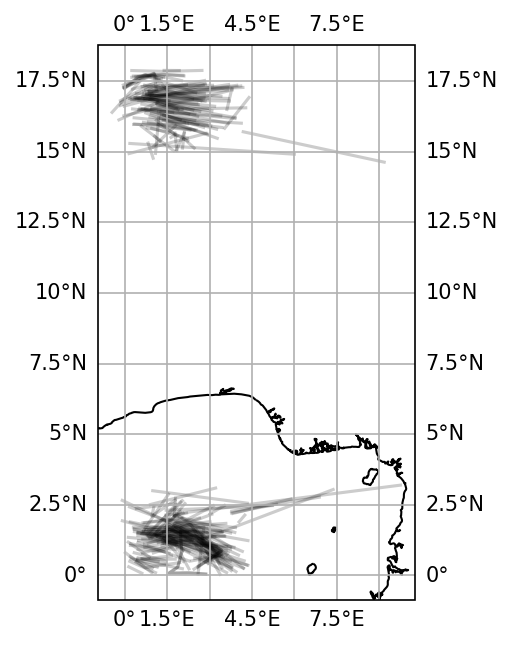

In [10]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": cartopy.crs.PlateCarree()})
fig.set_dpi(150)
for n in range(ds.sizes["trajectory"]):
    ax.plot(
        *ds.isel(trajectory=n)[["lon", "lat"]].dropna("obs").data_vars.values(),
        color="k", alpha=0.2,
        transform=cartopy.crs.PlateCarree(),
    )
ax.coastlines()
# ax.set_extent([
#     np.min(fieldset.U.grid.lon),
#     np.max(fieldset.U.grid.lon),
#     np.min(fieldset.U.grid.lat),
#     np.max(fieldset.U.grid.lat),
# ])
ax.gridlines(draw_labels=True);